In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'balance_ratio' : 0.5,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_05_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1972301, 828)
(1972301, 8)
validation
(232170, 828)
(232170, 8)
test
(287409, 828)
(287409, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/198 [..............................] - ETA: 5:39 - loss: 2.1629 - STD: 0.0953 - MAE: 0.2131

  4/198 [..............................] - ETA: 4s - loss: 2.0997 - STD: 0.0414 - MAE: 0.2169  

  7/198 [>.............................] - ETA: 4s - loss: 2.0898 - STD: 0.0388 - MAE: 0.2170

 10/198 [>.............................] - ETA: 4s - loss: 2.0795 - STD: 0.0403 - MAE: 0.2167

 13/198 [>.............................] - ETA: 4s - loss: 2.0739 - STD: 0.0400 - MAE: 0.2166

 16/198 [=>............................] - ETA: 4s - loss: 2.0688 - STD: 0.0390 - MAE: 0.2166

 19/198 [=>............................] - ETA: 4s - loss: 2.0633 - STD: 0.0384 - MAE: 0.2164

 22/198 [==>...........................] - ETA: 4s - loss: 2.0582 - STD: 0.0379 - MAE: 0.2163

 25/198 [==>...........................] - ETA: 3s - loss: 2.0519 - STD: 0.0370 - MAE: 0.2162

 28/198 [===>..........................] - ETA: 3s - loss: 2.0437 - STD: 0.0376 - MAE: 0.2158

 31/198 [===>..........................] - ETA: 3s - loss: 2.0346 - STD: 0.0398 - MAE: 0.2153

 34/198 [====>.........................] - ETA: 3s - loss: 2.0244 - STD: 0.0420 - MAE: 0.2148

 37/198 [====>.........................] - ETA: 3s - loss: 2.0142 - STD: 0.0441 - MAE: 0.2142

 40/198 [=====>........................] - ETA: 3s - loss: 2.0031 - STD: 0.0458 - MAE: 0.2137

 43/198 [=====>........................] - ETA: 3s - loss: 1.9917 - STD: 0.0477 - MAE: 0.2131

 46/198 [=====>........................] - ETA: 3s - loss: 1.9797 - STD: 0.0500 - MAE: 0.2125

 47/198 [======>.......................] - ETA: 5s - loss: 1.9786 - STD: 0.0507 - MAE: 0.2122

 50/198 [======>.......................] - ETA: 5s - loss: 1.9655 - STD: 0.0526 - MAE: 0.2116

 53/198 [=======>......................] - ETA: 5s - loss: 1.9514 - STD: 0.0546 - MAE: 0.2109

 56/198 [=======>......................] - ETA: 5s - loss: 1.9365 - STD: 0.0567 - MAE: 0.2101

 59/198 [=======>......................] - ETA: 4s - loss: 1.9209 - STD: 0.0590 - MAE: 0.2093

 62/198 [========>.....................] - ETA: 4s - loss: 1.9046 - STD: 0.0614 - MAE: 0.2084

 65/198 [========>.....................] - ETA: 4s - loss: 1.8885 - STD: 0.0638 - MAE: 0.2074

 68/198 [=========>....................] - ETA: 4s - loss: 1.8726 - STD: 0.0663 - MAE: 0.2065

 71/198 [=========>....................] - ETA: 4s - loss: 1.8569 - STD: 0.0688 - MAE: 0.2055

 74/198 [==========>...................] - ETA: 4s - loss: 1.8422 - STD: 0.0712 - MAE: 0.2046

 77/198 [==========>...................] - ETA: 3s - loss: 1.8279 - STD: 0.0736 - MAE: 0.2037

 80/198 [===========>..................] - ETA: 3s - loss: 1.8140 - STD: 0.0758 - MAE: 0.2028

 83/198 [===========>..................] - ETA: 3s - loss: 1.8006 - STD: 0.0780 - MAE: 0.2019

 86/198 [============>.................] - ETA: 3s - loss: 1.7878 - STD: 0.0801 - MAE: 0.2011

 89/198 [============>.................] - ETA: 3s - loss: 1.7756 - STD: 0.0821 - MAE: 0.2002

 92/198 [============>.................] - ETA: 3s - loss: 1.7638 - STD: 0.0839 - MAE: 0.1995

 95/198 [=============>................] - ETA: 3s - loss: 1.7526 - STD: 0.0858 - MAE: 0.1987

 98/198 [=============>................] - ETA: 3s - loss: 1.7419 - STD: 0.0875 - MAE: 0.1980

101/198 [==============>...............] - ETA: 2s - loss: 1.7313 - STD: 0.0893 - MAE: 0.1973

104/198 [==============>...............] - ETA: 2s - loss: 1.7213 - STD: 0.0909 - MAE: 0.1966

107/198 [===============>..............] - ETA: 2s - loss: 1.7116 - STD: 0.0925 - MAE: 0.1959

110/198 [===============>..............] - ETA: 2s - loss: 1.7023 - STD: 0.0941 - MAE: 0.1952

113/198 [================>.............] - ETA: 2s - loss: 1.6934 - STD: 0.0955 - MAE: 0.1946

116/198 [================>.............] - ETA: 2s - loss: 1.6847 - STD: 0.0970 - MAE: 0.1939

119/198 [=================>............] - ETA: 2s - loss: 1.6764 - STD: 0.0984 - MAE: 0.1933

122/198 [=================>............] - ETA: 2s - loss: 1.6683 - STD: 0.0997 - MAE: 0.1927

125/198 [=================>............] - ETA: 2s - loss: 1.6606 - STD: 0.1010 - MAE: 0.1922

128/198 [==================>...........] - ETA: 2s - loss: 1.6530 - STD: 0.1023 - MAE: 0.1916

131/198 [==================>...........] - ETA: 1s - loss: 1.6458 - STD: 0.1035 - MAE: 0.1911

134/198 [===================>..........] - ETA: 1s - loss: 1.6387 - STD: 0.1047 - MAE: 0.1905

137/198 [===================>..........] - ETA: 1s - loss: 1.6320 - STD: 0.1058 - MAE: 0.1900

140/198 [====================>.........] - ETA: 1s - loss: 1.6254 - STD: 0.1069 - MAE: 0.1895

143/198 [====================>.........] - ETA: 1s - loss: 1.6189 - STD: 0.1080 - MAE: 0.1890

146/198 [=====================>........] - ETA: 1s - loss: 1.6127 - STD: 0.1090 - MAE: 0.1885

149/198 [=====================>........] - ETA: 1s - loss: 1.6066 - STD: 0.1101 - MAE: 0.1881

152/198 [======================>.......] - ETA: 1s - loss: 1.6009 - STD: 0.1111 - MAE: 0.1876

155/198 [======================>.......] - ETA: 1s - loss: 1.5951 - STD: 0.1120 - MAE: 0.1872

158/198 [======================>.......] - ETA: 1s - loss: 1.5894 - STD: 0.1130 - MAE: 0.1868

161/198 [=======================>......] - ETA: 1s - loss: 1.5839 - STD: 0.1139 - MAE: 0.1863

164/198 [=======================>......] - ETA: 0s - loss: 1.5787 - STD: 0.1148 - MAE: 0.1859

167/198 [========================>.....] - ETA: 0s - loss: 1.5735 - STD: 0.1156 - MAE: 0.1855

170/198 [========================>.....] - ETA: 0s - loss: 1.5684 - STD: 0.1165 - MAE: 0.1851

173/198 [=========================>....] - ETA: 0s - loss: 1.5634 - STD: 0.1173 - MAE: 0.1847

176/198 [=========================>....] - ETA: 0s - loss: 1.5585 - STD: 0.1181 - MAE: 0.1843

179/198 [==========================>...] - ETA: 0s - loss: 1.5536 - STD: 0.1189 - MAE: 0.1840

182/198 [==========================>...] - ETA: 0s - loss: 1.5490 - STD: 0.1197 - MAE: 0.1836

185/198 [===========================>..] - ETA: 0s - loss: 1.5444 - STD: 0.1205 - MAE: 0.1832

188/198 [===========================>..] - ETA: 0s - loss: 1.5400 - STD: 0.1212 - MAE: 0.1829

191/198 [===========================>..] - ETA: 0s - loss: 1.5356 - STD: 0.1219 - MAE: 0.1825

194/198 [============================>.] - ETA: 0s - loss: 1.5313 - STD: 0.1226 - MAE: 0.1822

197/198 [============================>.] - ETA: 0s - loss: 1.5272 - STD: 0.1234 - MAE: 0.1818

198/198 [==============================] - 8s 31ms/step - loss: 1.5258 - STD: 0.1236 - MAE: 0.1817 - val_loss: 1.2985 - val_STD: 0.1690 - val_MAE: 0.1597


Epoch 2/10000


  1/198 [..............................] - ETA: 9s - loss: 1.2541 - STD: 0.1714 - MAE: 0.1584

  4/198 [..............................] - ETA: 4s - loss: 1.2516 - STD: 0.1701 - MAE: 0.1591

  7/198 [>.............................] - ETA: 4s - loss: 1.2468 - STD: 0.1705 - MAE: 0.1587

 10/198 [>.............................] - ETA: 4s - loss: 1.2465 - STD: 0.1711 - MAE: 0.1584

 13/198 [>.............................] - ETA: 4s - loss: 1.2468 - STD: 0.1713 - MAE: 0.1584

 16/198 [=>............................] - ETA: 4s - loss: 1.2465 - STD: 0.1714 - MAE: 0.1583

 19/198 [=>............................] - ETA: 4s - loss: 1.2458 - STD: 0.1716 - MAE: 0.1582

 22/198 [==>...........................] - ETA: 3s - loss: 1.2455 - STD: 0.1718 - MAE: 0.1581

 25/198 [==>...........................] - ETA: 3s - loss: 1.2438 - STD: 0.1720 - MAE: 0.1580

 28/198 [===>..........................] - ETA: 3s - loss: 1.2420 - STD: 0.1722 - MAE: 0.1578

 31/198 [===>..........................] - ETA: 3s - loss: 1.2412 - STD: 0.1725 - MAE: 0.1577

 34/198 [====>.........................] - ETA: 3s - loss: 1.2402 - STD: 0.1727 - MAE: 0.1575

 37/198 [====>.........................] - ETA: 3s - loss: 1.2392 - STD: 0.1728 - MAE: 0.1575

 40/198 [=====>........................] - ETA: 3s - loss: 1.2380 - STD: 0.1729 - MAE: 0.1574

 43/198 [=====>........................] - ETA: 3s - loss: 1.2357 - STD: 0.1732 - MAE: 0.1572

 46/198 [=====>........................] - ETA: 3s - loss: 1.2335 - STD: 0.1735 - MAE: 0.1570

 49/198 [======>.......................] - ETA: 3s - loss: 1.2316 - STD: 0.1737 - MAE: 0.1568

 52/198 [======>.......................] - ETA: 3s - loss: 1.2300 - STD: 0.1739 - MAE: 0.1566

 55/198 [=======>......................] - ETA: 3s - loss: 1.2288 - STD: 0.1741 - MAE: 0.1565

 58/198 [=======>......................] - ETA: 3s - loss: 1.2276 - STD: 0.1742 - MAE: 0.1564

 61/198 [========>.....................] - ETA: 3s - loss: 1.2262 - STD: 0.1744 - MAE: 0.1563

 64/198 [========>.....................] - ETA: 3s - loss: 1.2249 - STD: 0.1745 - MAE: 0.1562

 67/198 [=========>....................] - ETA: 2s - loss: 1.2235 - STD: 0.1747 - MAE: 0.1561

 70/198 [=========>....................] - ETA: 2s - loss: 1.2222 - STD: 0.1748 - MAE: 0.1559

 73/198 [==========>...................] - ETA: 2s - loss: 1.2210 - STD: 0.1750 - MAE: 0.1558

 76/198 [==========>...................] - ETA: 2s - loss: 1.2200 - STD: 0.1753 - MAE: 0.1557

 79/198 [==========>...................] - ETA: 2s - loss: 1.2195 - STD: 0.1755 - MAE: 0.1556

 82/198 [===========>..................] - ETA: 2s - loss: 1.2186 - STD: 0.1756 - MAE: 0.1554

 85/198 [===========>..................] - ETA: 2s - loss: 1.2176 - STD: 0.1758 - MAE: 0.1553

 88/198 [============>.................] - ETA: 2s - loss: 1.2167 - STD: 0.1760 - MAE: 0.1552

 91/198 [============>.................] - ETA: 2s - loss: 1.2164 - STD: 0.1761 - MAE: 0.1551

 94/198 [=============>................] - ETA: 2s - loss: 1.2156 - STD: 0.1763 - MAE: 0.1551

 97/198 [=============>................] - ETA: 2s - loss: 1.2150 - STD: 0.1765 - MAE: 0.1550

100/198 [==============>...............] - ETA: 2s - loss: 1.2141 - STD: 0.1766 - MAE: 0.1549

103/198 [==============>...............] - ETA: 2s - loss: 1.2131 - STD: 0.1767 - MAE: 0.1548

106/198 [===============>..............] - ETA: 2s - loss: 1.2119 - STD: 0.1768 - MAE: 0.1547

109/198 [===============>..............] - ETA: 2s - loss: 1.2108 - STD: 0.1770 - MAE: 0.1546

112/198 [===============>..............] - ETA: 1s - loss: 1.2097 - STD: 0.1771 - MAE: 0.1545

115/198 [================>.............] - ETA: 1s - loss: 1.2085 - STD: 0.1772 - MAE: 0.1544

118/198 [================>.............] - ETA: 1s - loss: 1.2074 - STD: 0.1774 - MAE: 0.1543

121/198 [=================>............] - ETA: 1s - loss: 1.2061 - STD: 0.1775 - MAE: 0.1541

124/198 [=================>............] - ETA: 1s - loss: 1.2048 - STD: 0.1777 - MAE: 0.1540

127/198 [==================>...........] - ETA: 1s - loss: 1.2033 - STD: 0.1779 - MAE: 0.1539

130/198 [==================>...........] - ETA: 1s - loss: 1.2021 - STD: 0.1780 - MAE: 0.1538

133/198 [===================>..........] - ETA: 1s - loss: 1.2008 - STD: 0.1782 - MAE: 0.1536

136/198 [===================>..........] - ETA: 1s - loss: 1.1995 - STD: 0.1784 - MAE: 0.1535

139/198 [====================>.........] - ETA: 1s - loss: 1.1982 - STD: 0.1785 - MAE: 0.1534

142/198 [====================>.........] - ETA: 1s - loss: 1.1971 - STD: 0.1787 - MAE: 0.1533

145/198 [====================>.........] - ETA: 1s - loss: 1.1958 - STD: 0.1788 - MAE: 0.1532

148/198 [=====================>........] - ETA: 1s - loss: 1.1949 - STD: 0.1790 - MAE: 0.1531

151/198 [=====================>........] - ETA: 1s - loss: 1.1939 - STD: 0.1791 - MAE: 0.1530

154/198 [======================>.......] - ETA: 0s - loss: 1.1927 - STD: 0.1792 - MAE: 0.1528

157/198 [======================>.......] - ETA: 0s - loss: 1.1916 - STD: 0.1794 - MAE: 0.1527

160/198 [=======================>......] - ETA: 0s - loss: 1.1909 - STD: 0.1796 - MAE: 0.1526

163/198 [=======================>......] - ETA: 0s - loss: 1.1903 - STD: 0.1797 - MAE: 0.1525

166/198 [========================>.....] - ETA: 0s - loss: 1.1893 - STD: 0.1798 - MAE: 0.1525

169/198 [========================>.....] - ETA: 0s - loss: 1.1886 - STD: 0.1800 - MAE: 0.1524

172/198 [=========================>....] - ETA: 0s - loss: 1.1881 - STD: 0.1801 - MAE: 0.1523

175/198 [=========================>....] - ETA: 0s - loss: 1.1872 - STD: 0.1802 - MAE: 0.1522

178/198 [=========================>....] - ETA: 0s - loss: 1.1863 - STD: 0.1803 - MAE: 0.1521

181/198 [==========================>...] - ETA: 0s - loss: 1.1853 - STD: 0.1805 - MAE: 0.1520

184/198 [==========================>...] - ETA: 0s - loss: 1.1843 - STD: 0.1806 - MAE: 0.1519

187/198 [===========================>..] - ETA: 0s - loss: 1.1833 - STD: 0.1807 - MAE: 0.1518

190/198 [===========================>..] - ETA: 0s - loss: 1.1825 - STD: 0.1809 - MAE: 0.1517

193/198 [============================>.] - ETA: 0s - loss: 1.1816 - STD: 0.1810 - MAE: 0.1516

196/198 [============================>.] - ETA: 0s - loss: 1.1806 - STD: 0.1811 - MAE: 0.1515

198/198 [==============================] - 5s 25ms/step - loss: 1.1802 - STD: 0.1812 - MAE: 0.1515 - val_loss: 1.1776 - val_STD: 0.1896 - val_MAE: 0.1465


Epoch 3/10000


  1/198 [..............................] - ETA: 9s - loss: 1.1312 - STD: 0.1888 - MAE: 0.1462

  4/198 [..............................] - ETA: 4s - loss: 1.1253 - STD: 0.1894 - MAE: 0.1455

  7/198 [>.............................] - ETA: 4s - loss: 1.1242 - STD: 0.1894 - MAE: 0.1455

 10/198 [>.............................] - ETA: 4s - loss: 1.1213 - STD: 0.1895 - MAE: 0.1453

 13/198 [>.............................] - ETA: 4s - loss: 1.1196 - STD: 0.1896 - MAE: 0.1451

 16/198 [=>............................] - ETA: 4s - loss: 1.1176 - STD: 0.1898 - MAE: 0.1449

 19/198 [=>............................] - ETA: 4s - loss: 1.1161 - STD: 0.1899 - MAE: 0.1448

 22/198 [==>...........................] - ETA: 4s - loss: 1.1153 - STD: 0.1901 - MAE: 0.1447

 25/198 [==>...........................] - ETA: 4s - loss: 1.1145 - STD: 0.1903 - MAE: 0.1446

 28/198 [===>..........................] - ETA: 3s - loss: 1.1137 - STD: 0.1904 - MAE: 0.1445

 31/198 [===>..........................] - ETA: 3s - loss: 1.1128 - STD: 0.1905 - MAE: 0.1444

 34/198 [====>.........................] - ETA: 3s - loss: 1.1119 - STD: 0.1905 - MAE: 0.1444

 36/198 [====>.........................] - ETA: 3s - loss: 1.1113 - STD: 0.1907 - MAE: 0.1443

 39/198 [====>.........................] - ETA: 3s - loss: 1.1102 - STD: 0.1908 - MAE: 0.1442

 42/198 [=====>........................] - ETA: 3s - loss: 1.1097 - STD: 0.1909 - MAE: 0.1441

 45/198 [=====>........................] - ETA: 3s - loss: 1.1095 - STD: 0.1911 - MAE: 0.1440

 48/198 [======>.......................] - ETA: 3s - loss: 1.1093 - STD: 0.1912 - MAE: 0.1439

 51/198 [======>.......................] - ETA: 3s - loss: 1.1090 - STD: 0.1913 - MAE: 0.1439

 54/198 [=======>......................] - ETA: 3s - loss: 1.1083 - STD: 0.1915 - MAE: 0.1438

 57/198 [=======>......................] - ETA: 3s - loss: 1.1081 - STD: 0.1916 - MAE: 0.1437

 59/198 [=======>......................] - ETA: 3s - loss: 1.1085 - STD: 0.1916 - MAE: 0.1437

 62/198 [========>.....................] - ETA: 3s - loss: 1.1083 - STD: 0.1917 - MAE: 0.1437

 65/198 [========>.....................] - ETA: 3s - loss: 1.1079 - STD: 0.1918 - MAE: 0.1436

 68/198 [=========>....................] - ETA: 2s - loss: 1.1074 - STD: 0.1919 - MAE: 0.1435

 71/198 [=========>....................] - ETA: 2s - loss: 1.1067 - STD: 0.1919 - MAE: 0.1435

 74/198 [==========>...................] - ETA: 2s - loss: 1.1054 - STD: 0.1920 - MAE: 0.1434

 77/198 [==========>...................] - ETA: 2s - loss: 1.1040 - STD: 0.1921 - MAE: 0.1433

 80/198 [===========>..................] - ETA: 2s - loss: 1.1036 - STD: 0.1922 - MAE: 0.1432

 83/198 [===========>..................] - ETA: 2s - loss: 1.1023 - STD: 0.1924 - MAE: 0.1431

 86/198 [============>.................] - ETA: 2s - loss: 1.1014 - STD: 0.1925 - MAE: 0.1430

 89/198 [============>.................] - ETA: 2s - loss: 1.1005 - STD: 0.1926 - MAE: 0.1429

 92/198 [============>.................] - ETA: 2s - loss: 1.0997 - STD: 0.1927 - MAE: 0.1428

 95/198 [=============>................] - ETA: 2s - loss: 1.0989 - STD: 0.1927 - MAE: 0.1427

 98/198 [=============>................] - ETA: 2s - loss: 1.0980 - STD: 0.1928 - MAE: 0.1427

101/198 [==============>...............] - ETA: 2s - loss: 1.0971 - STD: 0.1929 - MAE: 0.1426

104/198 [==============>...............] - ETA: 2s - loss: 1.0963 - STD: 0.1930 - MAE: 0.1425

107/198 [===============>..............] - ETA: 2s - loss: 1.0956 - STD: 0.1932 - MAE: 0.1424

110/198 [===============>..............] - ETA: 2s - loss: 1.0949 - STD: 0.1933 - MAE: 0.1423

113/198 [================>.............] - ETA: 1s - loss: 1.0947 - STD: 0.1934 - MAE: 0.1423

116/198 [================>.............] - ETA: 1s - loss: 1.0948 - STD: 0.1935 - MAE: 0.1422

119/198 [=================>............] - ETA: 1s - loss: 1.0940 - STD: 0.1936 - MAE: 0.1421

122/198 [=================>............] - ETA: 1s - loss: 1.0931 - STD: 0.1937 - MAE: 0.1421

125/198 [=================>............] - ETA: 1s - loss: 1.0923 - STD: 0.1938 - MAE: 0.1420

128/198 [==================>...........] - ETA: 1s - loss: 1.0918 - STD: 0.1939 - MAE: 0.1419

131/198 [==================>...........] - ETA: 1s - loss: 1.0914 - STD: 0.1940 - MAE: 0.1419

134/198 [===================>..........] - ETA: 1s - loss: 1.0910 - STD: 0.1941 - MAE: 0.1418

137/198 [===================>..........] - ETA: 1s - loss: 1.0907 - STD: 0.1942 - MAE: 0.1418

140/198 [====================>.........] - ETA: 1s - loss: 1.0900 - STD: 0.1943 - MAE: 0.1417

143/198 [====================>.........] - ETA: 1s - loss: 1.0897 - STD: 0.1944 - MAE: 0.1416

146/198 [=====================>........] - ETA: 1s - loss: 1.0891 - STD: 0.1944 - MAE: 0.1416

149/198 [=====================>........] - ETA: 1s - loss: 1.0885 - STD: 0.1945 - MAE: 0.1415

152/198 [======================>.......] - ETA: 1s - loss: 1.0878 - STD: 0.1946 - MAE: 0.1414

155/198 [======================>.......] - ETA: 0s - loss: 1.0870 - STD: 0.1946 - MAE: 0.1414

158/198 [======================>.......] - ETA: 0s - loss: 1.0863 - STD: 0.1947 - MAE: 0.1413

161/198 [=======================>......] - ETA: 0s - loss: 1.0854 - STD: 0.1948 - MAE: 0.1412

164/198 [=======================>......] - ETA: 0s - loss: 1.0847 - STD: 0.1949 - MAE: 0.1411

167/198 [========================>.....] - ETA: 0s - loss: 1.0842 - STD: 0.1950 - MAE: 0.1411

170/198 [========================>.....] - ETA: 0s - loss: 1.0834 - STD: 0.1951 - MAE: 0.1410

173/198 [=========================>....] - ETA: 0s - loss: 1.0828 - STD: 0.1952 - MAE: 0.1409

176/198 [=========================>....] - ETA: 0s - loss: 1.0821 - STD: 0.1952 - MAE: 0.1409

179/198 [==========================>...] - ETA: 0s - loss: 1.0818 - STD: 0.1953 - MAE: 0.1408

182/198 [==========================>...] - ETA: 0s - loss: 1.0813 - STD: 0.1954 - MAE: 0.1407

185/198 [===========================>..] - ETA: 0s - loss: 1.0810 - STD: 0.1955 - MAE: 0.1407

188/198 [===========================>..] - ETA: 0s - loss: 1.0804 - STD: 0.1956 - MAE: 0.1406

191/198 [===========================>..] - ETA: 0s - loss: 1.0799 - STD: 0.1956 - MAE: 0.1406

194/198 [============================>.] - ETA: 0s - loss: 1.0792 - STD: 0.1957 - MAE: 0.1405

197/198 [============================>.] - ETA: 0s - loss: 1.0784 - STD: 0.1958 - MAE: 0.1404

198/198 [==============================] - 5s 25ms/step - loss: 1.0783 - STD: 0.1958 - MAE: 0.1404 - val_loss: 1.1258 - val_STD: 0.2000 - val_MAE: 0.1392


Epoch 4/10000


  1/198 [..............................] - ETA: 9s - loss: 1.0741 - STD: 0.2026 - MAE: 0.1376

  4/198 [..............................] - ETA: 4s - loss: 1.0583 - STD: 0.2015 - MAE: 0.1372

  7/198 [>.............................] - ETA: 4s - loss: 1.0512 - STD: 0.2012 - MAE: 0.1369

 10/198 [>.............................] - ETA: 4s - loss: 1.0502 - STD: 0.2012 - MAE: 0.1368

 13/198 [>.............................] - ETA: 4s - loss: 1.0475 - STD: 0.2012 - MAE: 0.1367

 16/198 [=>............................] - ETA: 4s - loss: 1.0470 - STD: 0.2014 - MAE: 0.1366

 19/198 [=>............................] - ETA: 4s - loss: 1.0474 - STD: 0.2015 - MAE: 0.1365

 22/198 [==>...........................] - ETA: 4s - loss: 1.0486 - STD: 0.2015 - MAE: 0.1366

 25/198 [==>...........................] - ETA: 3s - loss: 1.0476 - STD: 0.2015 - MAE: 0.1365

 28/198 [===>..........................] - ETA: 3s - loss: 1.0461 - STD: 0.2016 - MAE: 0.1363

 31/198 [===>..........................] - ETA: 3s - loss: 1.0470 - STD: 0.2017 - MAE: 0.1363

 34/198 [====>.........................] - ETA: 3s - loss: 1.0479 - STD: 0.2017 - MAE: 0.1364

 37/198 [====>.........................] - ETA: 3s - loss: 1.0487 - STD: 0.2018 - MAE: 0.1364

 40/198 [=====>........................] - ETA: 3s - loss: 1.0491 - STD: 0.2018 - MAE: 0.1364

 43/198 [=====>........................] - ETA: 3s - loss: 1.0487 - STD: 0.2018 - MAE: 0.1364

 46/198 [=====>........................] - ETA: 3s - loss: 1.0481 - STD: 0.2018 - MAE: 0.1364

 49/198 [======>.......................] - ETA: 3s - loss: 1.0466 - STD: 0.2018 - MAE: 0.1363

 52/198 [======>.......................] - ETA: 3s - loss: 1.0460 - STD: 0.2019 - MAE: 0.1363

 55/198 [=======>......................] - ETA: 3s - loss: 1.0454 - STD: 0.2019 - MAE: 0.1362

 58/198 [=======>......................] - ETA: 3s - loss: 1.0445 - STD: 0.2019 - MAE: 0.1362

 61/198 [========>.....................] - ETA: 3s - loss: 1.0439 - STD: 0.2020 - MAE: 0.1361

 63/198 [========>.....................] - ETA: 3s - loss: 1.0437 - STD: 0.2020 - MAE: 0.1361

 65/198 [========>.....................] - ETA: 3s - loss: 1.0435 - STD: 0.2020 - MAE: 0.1360

 68/198 [=========>....................] - ETA: 2s - loss: 1.0433 - STD: 0.2021 - MAE: 0.1360

 71/198 [=========>....................] - ETA: 2s - loss: 1.0426 - STD: 0.2021 - MAE: 0.1359

 73/198 [==========>...................] - ETA: 2s - loss: 1.0421 - STD: 0.2022 - MAE: 0.1359

 76/198 [==========>...................] - ETA: 2s - loss: 1.0413 - STD: 0.2022 - MAE: 0.1359

 79/198 [==========>...................] - ETA: 2s - loss: 1.0407 - STD: 0.2022 - MAE: 0.1358

 82/198 [===========>..................] - ETA: 2s - loss: 1.0398 - STD: 0.2023 - MAE: 0.1357

 85/198 [===========>..................] - ETA: 2s - loss: 1.0389 - STD: 0.2023 - MAE: 0.1357

 88/198 [============>.................] - ETA: 2s - loss: 1.0377 - STD: 0.2024 - MAE: 0.1356

 91/198 [============>.................] - ETA: 2s - loss: 1.0369 - STD: 0.2024 - MAE: 0.1355

 94/198 [=============>................] - ETA: 2s - loss: 1.0358 - STD: 0.2025 - MAE: 0.1354

 97/198 [=============>................] - ETA: 2s - loss: 1.0348 - STD: 0.2026 - MAE: 0.1353

100/198 [==============>...............] - ETA: 2s - loss: 1.0344 - STD: 0.2027 - MAE: 0.1353

103/198 [==============>...............] - ETA: 2s - loss: 1.0346 - STD: 0.2027 - MAE: 0.1353

106/198 [===============>..............] - ETA: 2s - loss: 1.0343 - STD: 0.2028 - MAE: 0.1352

109/198 [===============>..............] - ETA: 2s - loss: 1.0335 - STD: 0.2028 - MAE: 0.1352

112/198 [===============>..............] - ETA: 1s - loss: 1.0332 - STD: 0.2029 - MAE: 0.1351

115/198 [================>.............] - ETA: 1s - loss: 1.0328 - STD: 0.2030 - MAE: 0.1351

118/198 [================>.............] - ETA: 1s - loss: 1.0327 - STD: 0.2030 - MAE: 0.1350

121/198 [=================>............] - ETA: 1s - loss: 1.0324 - STD: 0.2031 - MAE: 0.1350

124/198 [=================>............] - ETA: 1s - loss: 1.0317 - STD: 0.2031 - MAE: 0.1349

127/198 [==================>...........] - ETA: 1s - loss: 1.0316 - STD: 0.2031 - MAE: 0.1349

130/198 [==================>...........] - ETA: 1s - loss: 1.0317 - STD: 0.2032 - MAE: 0.1349

133/198 [===================>..........] - ETA: 1s - loss: 1.0321 - STD: 0.2032 - MAE: 0.1349

136/198 [===================>..........] - ETA: 1s - loss: 1.0322 - STD: 0.2033 - MAE: 0.1349

139/198 [====================>.........] - ETA: 1s - loss: 1.0322 - STD: 0.2033 - MAE: 0.1349

142/198 [====================>.........] - ETA: 1s - loss: 1.0320 - STD: 0.2033 - MAE: 0.1349

145/198 [====================>.........] - ETA: 1s - loss: 1.0318 - STD: 0.2034 - MAE: 0.1349

148/198 [=====================>........] - ETA: 1s - loss: 1.0315 - STD: 0.2034 - MAE: 0.1348

151/198 [=====================>........] - ETA: 1s - loss: 1.0311 - STD: 0.2034 - MAE: 0.1348

154/198 [======================>.......] - ETA: 1s - loss: 1.0308 - STD: 0.2034 - MAE: 0.1348

157/198 [======================>.......] - ETA: 0s - loss: 1.0306 - STD: 0.2035 - MAE: 0.1348

160/198 [=======================>......] - ETA: 0s - loss: 1.0300 - STD: 0.2035 - MAE: 0.1347

163/198 [=======================>......] - ETA: 0s - loss: 1.0294 - STD: 0.2035 - MAE: 0.1347

166/198 [========================>.....] - ETA: 0s - loss: 1.0289 - STD: 0.2035 - MAE: 0.1347

169/198 [========================>.....] - ETA: 0s - loss: 1.0284 - STD: 0.2036 - MAE: 0.1346

172/198 [=========================>....] - ETA: 0s - loss: 1.0278 - STD: 0.2036 - MAE: 0.1346

175/198 [=========================>....] - ETA: 0s - loss: 1.0275 - STD: 0.2037 - MAE: 0.1345

178/198 [=========================>....] - ETA: 0s - loss: 1.0269 - STD: 0.2037 - MAE: 0.1345

181/198 [==========================>...] - ETA: 0s - loss: 1.0263 - STD: 0.2038 - MAE: 0.1344

184/198 [==========================>...] - ETA: 0s - loss: 1.0256 - STD: 0.2038 - MAE: 0.1344

187/198 [===========================>..] - ETA: 0s - loss: 1.0255 - STD: 0.2039 - MAE: 0.1343

190/198 [===========================>..] - ETA: 0s - loss: 1.0252 - STD: 0.2039 - MAE: 0.1343

193/198 [============================>.] - ETA: 0s - loss: 1.0247 - STD: 0.2040 - MAE: 0.1342

196/198 [============================>.] - ETA: 0s - loss: 1.0243 - STD: 0.2040 - MAE: 0.1342

198/198 [==============================] - 5s 25ms/step - loss: 1.0241 - STD: 0.2041 - MAE: 0.1342 - val_loss: 1.1016 - val_STD: 0.2058 - val_MAE: 0.1343


Epoch 5/10000


  1/198 [..............................] - ETA: 10s - loss: 1.0132 - STD: 0.2071 - MAE: 0.1322

  4/198 [..............................] - ETA: 4s - loss: 1.0203 - STD: 0.2071 - MAE: 0.1328 

  7/198 [>.............................] - ETA: 4s - loss: 1.0209 - STD: 0.2077 - MAE: 0.1325

 10/198 [>.............................] - ETA: 4s - loss: 1.0176 - STD: 0.2073 - MAE: 0.1325

 13/198 [>.............................] - ETA: 4s - loss: 1.0117 - STD: 0.2074 - MAE: 0.1321

 16/198 [=>............................] - ETA: 4s - loss: 1.0072 - STD: 0.2073 - MAE: 0.1318

 19/198 [=>............................] - ETA: 4s - loss: 1.0052 - STD: 0.2073 - MAE: 0.1317

 22/198 [==>...........................] - ETA: 4s - loss: 1.0042 - STD: 0.2073 - MAE: 0.1317

 25/198 [==>...........................] - ETA: 3s - loss: 1.0028 - STD: 0.2074 - MAE: 0.1316

 28/198 [===>..........................] - ETA: 3s - loss: 1.0011 - STD: 0.2074 - MAE: 0.1315

 31/198 [===>..........................] - ETA: 3s - loss: 0.9997 - STD: 0.2074 - MAE: 0.1314

 34/198 [====>.........................] - ETA: 3s - loss: 0.9992 - STD: 0.2075 - MAE: 0.1313

 37/198 [====>.........................] - ETA: 3s - loss: 0.9991 - STD: 0.2075 - MAE: 0.1313

 40/198 [=====>........................] - ETA: 3s - loss: 0.9988 - STD: 0.2076 - MAE: 0.1313

 43/198 [=====>........................] - ETA: 3s - loss: 0.9986 - STD: 0.2076 - MAE: 0.1313

 46/198 [=====>........................] - ETA: 3s - loss: 1.0012 - STD: 0.2077 - MAE: 0.1313

 49/198 [======>.......................] - ETA: 3s - loss: 1.0002 - STD: 0.2078 - MAE: 0.1312

 52/198 [======>.......................] - ETA: 3s - loss: 1.0009 - STD: 0.2079 - MAE: 0.1312

 55/198 [=======>......................] - ETA: 3s - loss: 1.0009 - STD: 0.2079 - MAE: 0.1312

 58/198 [=======>......................] - ETA: 3s - loss: 1.0009 - STD: 0.2080 - MAE: 0.1312

 61/198 [========>.....................] - ETA: 3s - loss: 1.0001 - STD: 0.2080 - MAE: 0.1312

 64/198 [========>.....................] - ETA: 3s - loss: 0.9997 - STD: 0.2080 - MAE: 0.1312

 67/198 [=========>....................] - ETA: 2s - loss: 0.9991 - STD: 0.2080 - MAE: 0.1311

 70/198 [=========>....................] - ETA: 2s - loss: 0.9985 - STD: 0.2080 - MAE: 0.1311

 73/198 [==========>...................] - ETA: 2s - loss: 0.9981 - STD: 0.2080 - MAE: 0.1311

 76/198 [==========>...................] - ETA: 2s - loss: 0.9974 - STD: 0.2080 - MAE: 0.1310

 79/198 [==========>...................] - ETA: 2s - loss: 0.9967 - STD: 0.2081 - MAE: 0.1310

 82/198 [===========>..................] - ETA: 2s - loss: 0.9962 - STD: 0.2081 - MAE: 0.1310

 85/198 [===========>..................] - ETA: 2s - loss: 0.9954 - STD: 0.2081 - MAE: 0.1309

 88/198 [============>.................] - ETA: 2s - loss: 0.9948 - STD: 0.2081 - MAE: 0.1309

 91/198 [============>.................] - ETA: 2s - loss: 0.9943 - STD: 0.2082 - MAE: 0.1308

 94/198 [=============>................] - ETA: 2s - loss: 0.9935 - STD: 0.2082 - MAE: 0.1307

 97/198 [=============>................] - ETA: 2s - loss: 0.9940 - STD: 0.2083 - MAE: 0.1307

100/198 [==============>...............] - ETA: 2s - loss: 0.9943 - STD: 0.2083 - MAE: 0.1307

103/198 [==============>...............] - ETA: 2s - loss: 0.9942 - STD: 0.2084 - MAE: 0.1307

106/198 [===============>..............] - ETA: 2s - loss: 0.9938 - STD: 0.2084 - MAE: 0.1307

109/198 [===============>..............] - ETA: 2s - loss: 0.9939 - STD: 0.2084 - MAE: 0.1307

112/198 [===============>..............] - ETA: 1s - loss: 0.9936 - STD: 0.2084 - MAE: 0.1307

115/198 [================>.............] - ETA: 1s - loss: 0.9933 - STD: 0.2085 - MAE: 0.1306

118/198 [================>.............] - ETA: 1s - loss: 0.9930 - STD: 0.2085 - MAE: 0.1306

121/198 [=================>............] - ETA: 1s - loss: 0.9925 - STD: 0.2085 - MAE: 0.1306

124/198 [=================>............] - ETA: 1s - loss: 0.9918 - STD: 0.2085 - MAE: 0.1305

127/198 [==================>...........] - ETA: 1s - loss: 0.9915 - STD: 0.2085 - MAE: 0.1305

130/198 [==================>...........] - ETA: 1s - loss: 0.9909 - STD: 0.2086 - MAE: 0.1304

133/198 [===================>..........] - ETA: 1s - loss: 0.9904 - STD: 0.2086 - MAE: 0.1304

136/198 [===================>..........] - ETA: 1s - loss: 0.9899 - STD: 0.2086 - MAE: 0.1304

139/198 [====================>.........] - ETA: 1s - loss: 0.9904 - STD: 0.2087 - MAE: 0.1304

142/198 [====================>.........] - ETA: 1s - loss: 0.9904 - STD: 0.2087 - MAE: 0.1304

145/198 [====================>.........] - ETA: 1s - loss: 0.9901 - STD: 0.2087 - MAE: 0.1303

148/198 [=====================>........] - ETA: 1s - loss: 0.9899 - STD: 0.2088 - MAE: 0.1303

151/198 [=====================>........] - ETA: 1s - loss: 0.9895 - STD: 0.2088 - MAE: 0.1303

154/198 [======================>.......] - ETA: 0s - loss: 0.9890 - STD: 0.2089 - MAE: 0.1302

157/198 [======================>.......] - ETA: 0s - loss: 0.9888 - STD: 0.2089 - MAE: 0.1302

160/198 [=======================>......] - ETA: 0s - loss: 0.9885 - STD: 0.2090 - MAE: 0.1302

163/198 [=======================>......] - ETA: 0s - loss: 0.9883 - STD: 0.2090 - MAE: 0.1301

166/198 [========================>.....] - ETA: 0s - loss: 0.9880 - STD: 0.2090 - MAE: 0.1301

169/198 [========================>.....] - ETA: 0s - loss: 0.9875 - STD: 0.2090 - MAE: 0.1301

172/198 [=========================>....] - ETA: 0s - loss: 0.9868 - STD: 0.2091 - MAE: 0.1300

175/198 [=========================>....] - ETA: 0s - loss: 0.9864 - STD: 0.2091 - MAE: 0.1300

178/198 [=========================>....] - ETA: 0s - loss: 0.9862 - STD: 0.2091 - MAE: 0.1300

181/198 [==========================>...] - ETA: 0s - loss: 0.9860 - STD: 0.2092 - MAE: 0.1299

184/198 [==========================>...] - ETA: 0s - loss: 0.9856 - STD: 0.2092 - MAE: 0.1299

187/198 [===========================>..] - ETA: 0s - loss: 0.9853 - STD: 0.2093 - MAE: 0.1299

190/198 [===========================>..] - ETA: 0s - loss: 0.9854 - STD: 0.2093 - MAE: 0.1298

193/198 [============================>.] - ETA: 0s - loss: 0.9849 - STD: 0.2093 - MAE: 0.1298

196/198 [============================>.] - ETA: 0s - loss: 0.9847 - STD: 0.2094 - MAE: 0.1298

198/198 [==============================] - 5s 25ms/step - loss: 0.9847 - STD: 0.2094 - MAE: 0.1298 - val_loss: 1.0705 - val_STD: 0.2098 - val_MAE: 0.1316


Epoch 6/10000


  1/198 [..............................] - ETA: 9s - loss: 0.9654 - STD: 0.2112 - MAE: 0.1275

  3/198 [..............................] - ETA: 5s - loss: 0.9765 - STD: 0.2113 - MAE: 0.1284

  6/198 [..............................] - ETA: 4s - loss: 0.9725 - STD: 0.2118 - MAE: 0.1282

  9/198 [>.............................] - ETA: 4s - loss: 0.9738 - STD: 0.2115 - MAE: 0.1284

 12/198 [>.............................] - ETA: 4s - loss: 0.9769 - STD: 0.2113 - MAE: 0.1287

 15/198 [=>............................] - ETA: 4s - loss: 0.9776 - STD: 0.2113 - MAE: 0.1287

 18/198 [=>............................] - ETA: 4s - loss: 0.9747 - STD: 0.2114 - MAE: 0.1285

 21/198 [==>...........................] - ETA: 4s - loss: 0.9727 - STD: 0.2113 - MAE: 0.1284

 24/198 [==>...........................] - ETA: 3s - loss: 0.9716 - STD: 0.2113 - MAE: 0.1283

 27/198 [===>..........................] - ETA: 3s - loss: 0.9747 - STD: 0.2115 - MAE: 0.1284

 30/198 [===>..........................] - ETA: 3s - loss: 0.9738 - STD: 0.2116 - MAE: 0.1283

 33/198 [====>.........................] - ETA: 3s - loss: 0.9735 - STD: 0.2117 - MAE: 0.1282

 36/198 [====>.........................] - ETA: 3s - loss: 0.9734 - STD: 0.2117 - MAE: 0.1282

 39/198 [====>.........................] - ETA: 3s - loss: 0.9724 - STD: 0.2117 - MAE: 0.1281

 42/198 [=====>........................] - ETA: 3s - loss: 0.9716 - STD: 0.2117 - MAE: 0.1281

 45/198 [=====>........................] - ETA: 3s - loss: 0.9712 - STD: 0.2117 - MAE: 0.1281

 48/198 [======>.......................] - ETA: 3s - loss: 0.9709 - STD: 0.2117 - MAE: 0.1281

 51/198 [======>.......................] - ETA: 3s - loss: 0.9700 - STD: 0.2117 - MAE: 0.1280

 54/198 [=======>......................] - ETA: 3s - loss: 0.9693 - STD: 0.2118 - MAE: 0.1279

 57/198 [=======>......................] - ETA: 3s - loss: 0.9699 - STD: 0.2119 - MAE: 0.1279

 60/198 [========>.....................] - ETA: 3s - loss: 0.9705 - STD: 0.2119 - MAE: 0.1279

 63/198 [========>.....................] - ETA: 3s - loss: 0.9699 - STD: 0.2119 - MAE: 0.1279

 66/198 [=========>....................] - ETA: 3s - loss: 0.9705 - STD: 0.2119 - MAE: 0.1279

 69/198 [=========>....................] - ETA: 2s - loss: 0.9696 - STD: 0.2119 - MAE: 0.1279

 72/198 [=========>....................] - ETA: 2s - loss: 0.9692 - STD: 0.2120 - MAE: 0.1278

 75/198 [==========>...................] - ETA: 2s - loss: 0.9686 - STD: 0.2120 - MAE: 0.1278

 78/198 [==========>...................] - ETA: 2s - loss: 0.9678 - STD: 0.2120 - MAE: 0.1277

 81/198 [===========>..................] - ETA: 2s - loss: 0.9669 - STD: 0.2120 - MAE: 0.1277

 84/198 [===========>..................] - ETA: 2s - loss: 0.9666 - STD: 0.2121 - MAE: 0.1276

 87/198 [============>.................] - ETA: 2s - loss: 0.9661 - STD: 0.2121 - MAE: 0.1276

 90/198 [============>.................] - ETA: 2s - loss: 0.9655 - STD: 0.2122 - MAE: 0.1275

 93/198 [=============>................] - ETA: 2s - loss: 0.9651 - STD: 0.2122 - MAE: 0.1275

 96/198 [=============>................] - ETA: 2s - loss: 0.9655 - STD: 0.2123 - MAE: 0.1275

 99/198 [==============>...............] - ETA: 2s - loss: 0.9672 - STD: 0.2123 - MAE: 0.1275

102/198 [==============>...............] - ETA: 2s - loss: 0.9674 - STD: 0.2124 - MAE: 0.1275

105/198 [==============>...............] - ETA: 2s - loss: 0.9672 - STD: 0.2124 - MAE: 0.1275

108/198 [===============>..............] - ETA: 2s - loss: 0.9669 - STD: 0.2124 - MAE: 0.1275

111/198 [===============>..............] - ETA: 1s - loss: 0.9668 - STD: 0.2124 - MAE: 0.1275

114/198 [================>.............] - ETA: 1s - loss: 0.9665 - STD: 0.2124 - MAE: 0.1275

117/198 [================>.............] - ETA: 1s - loss: 0.9661 - STD: 0.2124 - MAE: 0.1275

120/198 [=================>............] - ETA: 1s - loss: 0.9656 - STD: 0.2124 - MAE: 0.1274

123/198 [=================>............] - ETA: 1s - loss: 0.9656 - STD: 0.2125 - MAE: 0.1274

126/198 [==================>...........] - ETA: 1s - loss: 0.9651 - STD: 0.2125 - MAE: 0.1274

129/198 [==================>...........] - ETA: 1s - loss: 0.9644 - STD: 0.2125 - MAE: 0.1273

132/198 [===================>..........] - ETA: 1s - loss: 0.9640 - STD: 0.2125 - MAE: 0.1273

135/198 [===================>..........] - ETA: 1s - loss: 0.9636 - STD: 0.2125 - MAE: 0.1273

138/198 [===================>..........] - ETA: 1s - loss: 0.9632 - STD: 0.2126 - MAE: 0.1272

141/198 [====================>.........] - ETA: 1s - loss: 0.9629 - STD: 0.2126 - MAE: 0.1272

144/198 [====================>.........] - ETA: 1s - loss: 0.9629 - STD: 0.2126 - MAE: 0.1272

147/198 [=====================>........] - ETA: 1s - loss: 0.9627 - STD: 0.2127 - MAE: 0.1271

150/198 [=====================>........] - ETA: 1s - loss: 0.9623 - STD: 0.2127 - MAE: 0.1271

153/198 [======================>.......] - ETA: 1s - loss: 0.9620 - STD: 0.2127 - MAE: 0.1271

156/198 [======================>.......] - ETA: 0s - loss: 0.9617 - STD: 0.2128 - MAE: 0.1270

159/198 [=======================>......] - ETA: 0s - loss: 0.9614 - STD: 0.2128 - MAE: 0.1270

162/198 [=======================>......] - ETA: 0s - loss: 0.9612 - STD: 0.2128 - MAE: 0.1270

165/198 [========================>.....] - ETA: 0s - loss: 0.9614 - STD: 0.2129 - MAE: 0.1270

168/198 [========================>.....] - ETA: 0s - loss: 0.9612 - STD: 0.2129 - MAE: 0.1269

171/198 [========================>.....] - ETA: 0s - loss: 0.9609 - STD: 0.2129 - MAE: 0.1269

174/198 [=========================>....] - ETA: 0s - loss: 0.9605 - STD: 0.2130 - MAE: 0.1269

177/198 [=========================>....] - ETA: 0s - loss: 0.9601 - STD: 0.2130 - MAE: 0.1268

180/198 [==========================>...] - ETA: 0s - loss: 0.9599 - STD: 0.2130 - MAE: 0.1268

183/198 [==========================>...] - ETA: 0s - loss: 0.9594 - STD: 0.2130 - MAE: 0.1268

186/198 [===========================>..] - ETA: 0s - loss: 0.9591 - STD: 0.2131 - MAE: 0.1268

189/198 [===========================>..] - ETA: 0s - loss: 0.9588 - STD: 0.2131 - MAE: 0.1267

192/198 [============================>.] - ETA: 0s - loss: 0.9584 - STD: 0.2131 - MAE: 0.1267

195/198 [============================>.] - ETA: 0s - loss: 0.9585 - STD: 0.2132 - MAE: 0.1267

198/198 [==============================] - ETA: 0s - loss: 0.9588 - STD: 0.2132 - MAE: 0.1267

198/198 [==============================] - 5s 25ms/step - loss: 0.9588 - STD: 0.2132 - MAE: 0.1267 - val_loss: 1.0734 - val_STD: 0.2141 - val_MAE: 0.1310


Epoch 7/10000


  1/198 [..............................] - ETA: 9s - loss: 0.9910 - STD: 0.2156 - MAE: 0.1275

  4/198 [..............................] - ETA: 4s - loss: 0.9565 - STD: 0.2162 - MAE: 0.1253

  7/198 [>.............................] - ETA: 4s - loss: 0.9697 - STD: 0.2157 - MAE: 0.1263

 10/198 [>.............................] - ETA: 4s - loss: 0.9599 - STD: 0.2156 - MAE: 0.1258

 13/198 [>.............................] - ETA: 4s - loss: 0.9562 - STD: 0.2156 - MAE: 0.1255

 16/198 [=>............................] - ETA: 4s - loss: 0.9543 - STD: 0.2154 - MAE: 0.1255

 19/198 [=>............................] - ETA: 4s - loss: 0.9531 - STD: 0.2152 - MAE: 0.1255

 22/198 [==>...........................] - ETA: 3s - loss: 0.9530 - STD: 0.2150 - MAE: 0.1256

 25/198 [==>...........................] - ETA: 3s - loss: 0.9500 - STD: 0.2150 - MAE: 0.1254

 28/198 [===>..........................] - ETA: 3s - loss: 0.9485 - STD: 0.2150 - MAE: 0.1253

 31/198 [===>..........................] - ETA: 3s - loss: 0.9470 - STD: 0.2150 - MAE: 0.1252

 34/198 [====>.........................] - ETA: 3s - loss: 0.9453 - STD: 0.2152 - MAE: 0.1250

 37/198 [====>.........................] - ETA: 3s - loss: 0.9465 - STD: 0.2153 - MAE: 0.1251

 40/198 [=====>........................] - ETA: 3s - loss: 0.9473 - STD: 0.2154 - MAE: 0.1251

 43/198 [=====>........................] - ETA: 3s - loss: 0.9492 - STD: 0.2154 - MAE: 0.1252

 46/198 [=====>........................] - ETA: 3s - loss: 0.9505 - STD: 0.2154 - MAE: 0.1253

 49/198 [======>.......................] - ETA: 3s - loss: 0.9509 - STD: 0.2153 - MAE: 0.1253

 52/198 [======>.......................] - ETA: 3s - loss: 0.9516 - STD: 0.2153 - MAE: 0.1254

 55/198 [=======>......................] - ETA: 3s - loss: 0.9515 - STD: 0.2153 - MAE: 0.1253

 58/198 [=======>......................] - ETA: 3s - loss: 0.9511 - STD: 0.2153 - MAE: 0.1253

 61/198 [========>.....................] - ETA: 3s - loss: 0.9508 - STD: 0.2152 - MAE: 0.1253

 64/198 [========>.....................] - ETA: 3s - loss: 0.9499 - STD: 0.2152 - MAE: 0.1253

 67/198 [=========>....................] - ETA: 2s - loss: 0.9490 - STD: 0.2152 - MAE: 0.1252

 70/198 [=========>....................] - ETA: 2s - loss: 0.9487 - STD: 0.2152 - MAE: 0.1252

 73/198 [==========>...................] - ETA: 2s - loss: 0.9478 - STD: 0.2152 - MAE: 0.1252

 76/198 [==========>...................] - ETA: 2s - loss: 0.9472 - STD: 0.2152 - MAE: 0.1251

 79/198 [==========>...................] - ETA: 2s - loss: 0.9463 - STD: 0.2152 - MAE: 0.1250

 82/198 [===========>..................] - ETA: 2s - loss: 0.9456 - STD: 0.2152 - MAE: 0.1250

 85/198 [===========>..................] - ETA: 2s - loss: 0.9452 - STD: 0.2152 - MAE: 0.1250

 88/198 [============>.................] - ETA: 2s - loss: 0.9451 - STD: 0.2153 - MAE: 0.1249

 91/198 [============>.................] - ETA: 2s - loss: 0.9443 - STD: 0.2153 - MAE: 0.1249

 94/198 [=============>................] - ETA: 2s - loss: 0.9439 - STD: 0.2153 - MAE: 0.1249

 97/198 [=============>................] - ETA: 2s - loss: 0.9433 - STD: 0.2154 - MAE: 0.1248

100/198 [==============>...............] - ETA: 2s - loss: 0.9426 - STD: 0.2154 - MAE: 0.1247

103/198 [==============>...............] - ETA: 2s - loss: 0.9420 - STD: 0.2155 - MAE: 0.1247

106/198 [===============>..............] - ETA: 2s - loss: 0.9416 - STD: 0.2155 - MAE: 0.1247

109/198 [===============>..............] - ETA: 2s - loss: 0.9413 - STD: 0.2156 - MAE: 0.1246

112/198 [===============>..............] - ETA: 1s - loss: 0.9409 - STD: 0.2156 - MAE: 0.1246

115/198 [================>.............] - ETA: 1s - loss: 0.9410 - STD: 0.2156 - MAE: 0.1246

118/198 [================>.............] - ETA: 1s - loss: 0.9410 - STD: 0.2156 - MAE: 0.1246

121/198 [=================>............] - ETA: 1s - loss: 0.9404 - STD: 0.2157 - MAE: 0.1245

124/198 [=================>............] - ETA: 1s - loss: 0.9402 - STD: 0.2157 - MAE: 0.1245

127/198 [==================>...........] - ETA: 1s - loss: 0.9402 - STD: 0.2157 - MAE: 0.1245

130/198 [==================>...........] - ETA: 1s - loss: 0.9403 - STD: 0.2158 - MAE: 0.1245

133/198 [===================>..........] - ETA: 1s - loss: 0.9400 - STD: 0.2158 - MAE: 0.1244

136/198 [===================>..........] - ETA: 1s - loss: 0.9401 - STD: 0.2158 - MAE: 0.1244

139/198 [====================>.........] - ETA: 1s - loss: 0.9399 - STD: 0.2159 - MAE: 0.1244

142/198 [====================>.........] - ETA: 1s - loss: 0.9400 - STD: 0.2159 - MAE: 0.1244

145/198 [====================>.........] - ETA: 1s - loss: 0.9399 - STD: 0.2159 - MAE: 0.1244

148/198 [=====================>........] - ETA: 1s - loss: 0.9396 - STD: 0.2159 - MAE: 0.1244

151/198 [=====================>........] - ETA: 1s - loss: 0.9393 - STD: 0.2159 - MAE: 0.1243

154/198 [======================>.......] - ETA: 0s - loss: 0.9391 - STD: 0.2160 - MAE: 0.1243

157/198 [======================>.......] - ETA: 0s - loss: 0.9393 - STD: 0.2160 - MAE: 0.1243

160/198 [=======================>......] - ETA: 0s - loss: 0.9393 - STD: 0.2160 - MAE: 0.1243

163/198 [=======================>......] - ETA: 0s - loss: 0.9392 - STD: 0.2161 - MAE: 0.1243

166/198 [========================>.....] - ETA: 0s - loss: 0.9392 - STD: 0.2161 - MAE: 0.1243

169/198 [========================>.....] - ETA: 0s - loss: 0.9391 - STD: 0.2161 - MAE: 0.1243

172/198 [=========================>....] - ETA: 0s - loss: 0.9388 - STD: 0.2161 - MAE: 0.1242

175/198 [=========================>....] - ETA: 0s - loss: 0.9385 - STD: 0.2161 - MAE: 0.1242

178/198 [=========================>....] - ETA: 0s - loss: 0.9384 - STD: 0.2161 - MAE: 0.1242

181/198 [==========================>...] - ETA: 0s - loss: 0.9380 - STD: 0.2161 - MAE: 0.1242

184/198 [==========================>...] - ETA: 0s - loss: 0.9377 - STD: 0.2162 - MAE: 0.1241

187/198 [===========================>..] - ETA: 0s - loss: 0.9376 - STD: 0.2162 - MAE: 0.1241

190/198 [===========================>..] - ETA: 0s - loss: 0.9372 - STD: 0.2162 - MAE: 0.1241

193/198 [============================>.] - ETA: 0s - loss: 0.9370 - STD: 0.2162 - MAE: 0.1241

196/198 [============================>.] - ETA: 0s - loss: 0.9366 - STD: 0.2163 - MAE: 0.1240

198/198 [==============================] - 5s 25ms/step - loss: 0.9366 - STD: 0.2163 - MAE: 0.1240 - val_loss: 1.0981 - val_STD: 0.2161 - val_MAE: 0.1296


Epoch 8/10000


  1/198 [..............................] - ETA: 8s - loss: 0.9384 - STD: 0.2177 - MAE: 0.1232

  4/198 [..............................] - ETA: 4s - loss: 0.9359 - STD: 0.2179 - MAE: 0.1233

  7/198 [>.............................] - ETA: 4s - loss: 0.9281 - STD: 0.2181 - MAE: 0.1227

 10/198 [>.............................] - ETA: 4s - loss: 0.9273 - STD: 0.2180 - MAE: 0.1227

 13/198 [>.............................] - ETA: 4s - loss: 0.9238 - STD: 0.2179 - MAE: 0.1225

 16/198 [=>............................] - ETA: 4s - loss: 0.9231 - STD: 0.2179 - MAE: 0.1225

 19/198 [=>............................] - ETA: 4s - loss: 0.9210 - STD: 0.2180 - MAE: 0.1223

 22/198 [==>...........................] - ETA: 3s - loss: 0.9204 - STD: 0.2180 - MAE: 0.1223

 25/198 [==>...........................] - ETA: 3s - loss: 0.9191 - STD: 0.2180 - MAE: 0.1222

 28/198 [===>..........................] - ETA: 3s - loss: 0.9194 - STD: 0.2180 - MAE: 0.1222

 31/198 [===>..........................] - ETA: 3s - loss: 0.9182 - STD: 0.2181 - MAE: 0.1221

 34/198 [====>.........................] - ETA: 3s - loss: 0.9178 - STD: 0.2182 - MAE: 0.1220

 37/198 [====>.........................] - ETA: 3s - loss: 0.9192 - STD: 0.2183 - MAE: 0.1221

 40/198 [=====>........................] - ETA: 3s - loss: 0.9197 - STD: 0.2183 - MAE: 0.1221

 43/198 [=====>........................] - ETA: 3s - loss: 0.9204 - STD: 0.2184 - MAE: 0.1221

 46/198 [=====>........................] - ETA: 3s - loss: 0.9237 - STD: 0.2184 - MAE: 0.1223

 49/198 [======>.......................] - ETA: 3s - loss: 0.9257 - STD: 0.2185 - MAE: 0.1224

 52/198 [======>.......................] - ETA: 3s - loss: 0.9278 - STD: 0.2185 - MAE: 0.1225

 55/198 [=======>......................] - ETA: 3s - loss: 0.9284 - STD: 0.2185 - MAE: 0.1226

 58/198 [=======>......................] - ETA: 3s - loss: 0.9288 - STD: 0.2185 - MAE: 0.1226

 61/198 [========>.....................] - ETA: 3s - loss: 0.9285 - STD: 0.2184 - MAE: 0.1227

 64/198 [========>.....................] - ETA: 2s - loss: 0.9285 - STD: 0.2183 - MAE: 0.1227

 67/198 [=========>....................] - ETA: 2s - loss: 0.9280 - STD: 0.2182 - MAE: 0.1227

 70/198 [=========>....................] - ETA: 2s - loss: 0.9275 - STD: 0.2181 - MAE: 0.1227

 73/198 [==========>...................] - ETA: 2s - loss: 0.9272 - STD: 0.2181 - MAE: 0.1227

 76/198 [==========>...................] - ETA: 2s - loss: 0.9265 - STD: 0.2181 - MAE: 0.1227

 79/198 [==========>...................] - ETA: 2s - loss: 0.9262 - STD: 0.2181 - MAE: 0.1226

 82/198 [===========>..................] - ETA: 2s - loss: 0.9260 - STD: 0.2181 - MAE: 0.1226

 85/198 [===========>..................] - ETA: 2s - loss: 0.9254 - STD: 0.2181 - MAE: 0.1225

 88/198 [============>.................] - ETA: 2s - loss: 0.9255 - STD: 0.2182 - MAE: 0.1225

 91/198 [============>.................] - ETA: 2s - loss: 0.9260 - STD: 0.2182 - MAE: 0.1226

 94/198 [=============>................] - ETA: 2s - loss: 0.9255 - STD: 0.2182 - MAE: 0.1225

 97/198 [=============>................] - ETA: 2s - loss: 0.9254 - STD: 0.2183 - MAE: 0.1225

100/198 [==============>...............] - ETA: 2s - loss: 0.9249 - STD: 0.2183 - MAE: 0.1225

103/198 [==============>...............] - ETA: 2s - loss: 0.9243 - STD: 0.2183 - MAE: 0.1224

106/198 [===============>..............] - ETA: 2s - loss: 0.9241 - STD: 0.2183 - MAE: 0.1224

109/198 [===============>..............] - ETA: 1s - loss: 0.9236 - STD: 0.2183 - MAE: 0.1224

112/198 [===============>..............] - ETA: 1s - loss: 0.9232 - STD: 0.2183 - MAE: 0.1224

115/198 [================>.............] - ETA: 1s - loss: 0.9229 - STD: 0.2183 - MAE: 0.1223

118/198 [================>.............] - ETA: 1s - loss: 0.9227 - STD: 0.2183 - MAE: 0.1223

121/198 [=================>............] - ETA: 1s - loss: 0.9222 - STD: 0.2183 - MAE: 0.1223

124/198 [=================>............] - ETA: 1s - loss: 0.9217 - STD: 0.2184 - MAE: 0.1222

127/198 [==================>...........] - ETA: 1s - loss: 0.9221 - STD: 0.2184 - MAE: 0.1222

130/198 [==================>...........] - ETA: 1s - loss: 0.9218 - STD: 0.2184 - MAE: 0.1222

133/198 [===================>..........] - ETA: 1s - loss: 0.9221 - STD: 0.2185 - MAE: 0.1222

136/198 [===================>..........] - ETA: 1s - loss: 0.9223 - STD: 0.2185 - MAE: 0.1222

139/198 [====================>.........] - ETA: 1s - loss: 0.9222 - STD: 0.2185 - MAE: 0.1222

142/198 [====================>.........] - ETA: 1s - loss: 0.9225 - STD: 0.2185 - MAE: 0.1222

145/198 [====================>.........] - ETA: 1s - loss: 0.9227 - STD: 0.2185 - MAE: 0.1222

148/198 [=====================>........] - ETA: 1s - loss: 0.9225 - STD: 0.2186 - MAE: 0.1222

151/198 [=====================>........] - ETA: 1s - loss: 0.9223 - STD: 0.2186 - MAE: 0.1222

154/198 [======================>.......] - ETA: 0s - loss: 0.9220 - STD: 0.2186 - MAE: 0.1221

157/198 [======================>.......] - ETA: 0s - loss: 0.9218 - STD: 0.2186 - MAE: 0.1221

160/198 [=======================>......] - ETA: 0s - loss: 0.9216 - STD: 0.2186 - MAE: 0.1221

163/198 [=======================>......] - ETA: 0s - loss: 0.9214 - STD: 0.2186 - MAE: 0.1221

166/198 [========================>.....] - ETA: 0s - loss: 0.9213 - STD: 0.2186 - MAE: 0.1221

169/198 [========================>.....] - ETA: 0s - loss: 0.9209 - STD: 0.2186 - MAE: 0.1221

172/198 [=========================>....] - ETA: 0s - loss: 0.9207 - STD: 0.2186 - MAE: 0.1220

175/198 [=========================>....] - ETA: 0s - loss: 0.9205 - STD: 0.2187 - MAE: 0.1220

178/198 [=========================>....] - ETA: 0s - loss: 0.9204 - STD: 0.2187 - MAE: 0.1220

181/198 [==========================>...] - ETA: 0s - loss: 0.9208 - STD: 0.2187 - MAE: 0.1220

184/198 [==========================>...] - ETA: 0s - loss: 0.9206 - STD: 0.2187 - MAE: 0.1220

187/198 [===========================>..] - ETA: 0s - loss: 0.9206 - STD: 0.2187 - MAE: 0.1220

190/198 [===========================>..] - ETA: 0s - loss: 0.9212 - STD: 0.2188 - MAE: 0.1220

193/198 [============================>.] - ETA: 0s - loss: 0.9211 - STD: 0.2188 - MAE: 0.1220

196/198 [============================>.] - ETA: 0s - loss: 0.9211 - STD: 0.2188 - MAE: 0.1220

198/198 [==============================] - 5s 25ms/step - loss: 0.9213 - STD: 0.2188 - MAE: 0.1220 - val_loss: 1.0792 - val_STD: 0.2159 - val_MAE: 0.1282


Epoch 9/10000


  1/198 [..............................] - ETA: 9s - loss: 0.9136 - STD: 0.2194 - MAE: 0.1213

  4/198 [..............................] - ETA: 4s - loss: 0.9181 - STD: 0.2190 - MAE: 0.1217

  7/198 [>.............................] - ETA: 4s - loss: 0.9112 - STD: 0.2191 - MAE: 0.1212

 10/198 [>.............................] - ETA: 4s - loss: 0.9117 - STD: 0.2189 - MAE: 0.1213

 13/198 [>.............................] - ETA: 4s - loss: 0.9116 - STD: 0.2191 - MAE: 0.1212

 16/198 [=>............................] - ETA: 4s - loss: 0.9093 - STD: 0.2193 - MAE: 0.1210

 19/198 [=>............................] - ETA: 4s - loss: 0.9082 - STD: 0.2195 - MAE: 0.1208

 22/198 [==>...........................] - ETA: 3s - loss: 0.9083 - STD: 0.2196 - MAE: 0.1208

 25/198 [==>...........................] - ETA: 3s - loss: 0.9076 - STD: 0.2197 - MAE: 0.1207

 28/198 [===>..........................] - ETA: 3s - loss: 0.9076 - STD: 0.2198 - MAE: 0.1207

 31/198 [===>..........................] - ETA: 3s - loss: 0.9085 - STD: 0.2198 - MAE: 0.1208

 34/198 [====>.........................] - ETA: 3s - loss: 0.9087 - STD: 0.2198 - MAE: 0.1208

 37/198 [====>.........................] - ETA: 3s - loss: 0.9099 - STD: 0.2198 - MAE: 0.1208

 40/198 [=====>........................] - ETA: 3s - loss: 0.9118 - STD: 0.2198 - MAE: 0.1210

 43/198 [=====>........................] - ETA: 3s - loss: 0.9143 - STD: 0.2199 - MAE: 0.1211

 46/198 [=====>........................] - ETA: 3s - loss: 0.9147 - STD: 0.2199 - MAE: 0.1211

 49/198 [======>.......................] - ETA: 3s - loss: 0.9150 - STD: 0.2199 - MAE: 0.1212

 52/198 [======>.......................] - ETA: 3s - loss: 0.9152 - STD: 0.2199 - MAE: 0.1212

 55/198 [=======>......................] - ETA: 3s - loss: 0.9152 - STD: 0.2198 - MAE: 0.1212

 58/198 [=======>......................] - ETA: 3s - loss: 0.9146 - STD: 0.2198 - MAE: 0.1212

 61/198 [========>.....................] - ETA: 3s - loss: 0.9136 - STD: 0.2198 - MAE: 0.1212

 64/198 [========>.....................] - ETA: 3s - loss: 0.9138 - STD: 0.2198 - MAE: 0.1211

 67/198 [=========>....................] - ETA: 2s - loss: 0.9133 - STD: 0.2198 - MAE: 0.1211

 70/198 [=========>....................] - ETA: 2s - loss: 0.9132 - STD: 0.2198 - MAE: 0.1211

 73/198 [==========>...................] - ETA: 2s - loss: 0.9135 - STD: 0.2198 - MAE: 0.1211

 76/198 [==========>...................] - ETA: 2s - loss: 0.9135 - STD: 0.2198 - MAE: 0.1211

 79/198 [==========>...................] - ETA: 2s - loss: 0.9133 - STD: 0.2198 - MAE: 0.1211

 82/198 [===========>..................] - ETA: 2s - loss: 0.9128 - STD: 0.2199 - MAE: 0.1210

 85/198 [===========>..................] - ETA: 2s - loss: 0.9122 - STD: 0.2199 - MAE: 0.1210

 88/198 [============>.................] - ETA: 2s - loss: 0.9118 - STD: 0.2199 - MAE: 0.1210

 91/198 [============>.................] - ETA: 2s - loss: 0.9117 - STD: 0.2199 - MAE: 0.1210

 94/198 [=============>................] - ETA: 2s - loss: 0.9118 - STD: 0.2199 - MAE: 0.1210

 97/198 [=============>................] - ETA: 2s - loss: 0.9115 - STD: 0.2200 - MAE: 0.1209

100/198 [==============>...............] - ETA: 2s - loss: 0.9112 - STD: 0.2200 - MAE: 0.1209

103/198 [==============>...............] - ETA: 2s - loss: 0.9106 - STD: 0.2200 - MAE: 0.1209

106/198 [===============>..............] - ETA: 2s - loss: 0.9105 - STD: 0.2200 - MAE: 0.1208

109/198 [===============>..............] - ETA: 2s - loss: 0.9099 - STD: 0.2201 - MAE: 0.1208

111/198 [===============>..............] - ETA: 1s - loss: 0.9098 - STD: 0.2201 - MAE: 0.1208

114/198 [================>.............] - ETA: 1s - loss: 0.9097 - STD: 0.2201 - MAE: 0.1208

117/198 [================>.............] - ETA: 1s - loss: 0.9097 - STD: 0.2201 - MAE: 0.1208

120/198 [=================>............] - ETA: 1s - loss: 0.9102 - STD: 0.2201 - MAE: 0.1208

123/198 [=================>............] - ETA: 1s - loss: 0.9100 - STD: 0.2202 - MAE: 0.1207

126/198 [==================>...........] - ETA: 1s - loss: 0.9099 - STD: 0.2202 - MAE: 0.1207

129/198 [==================>...........] - ETA: 1s - loss: 0.9094 - STD: 0.2202 - MAE: 0.1207

132/198 [===================>..........] - ETA: 1s - loss: 0.9090 - STD: 0.2202 - MAE: 0.1207

135/198 [===================>..........] - ETA: 1s - loss: 0.9087 - STD: 0.2202 - MAE: 0.1206

138/198 [===================>..........] - ETA: 1s - loss: 0.9082 - STD: 0.2203 - MAE: 0.1206

141/198 [====================>.........] - ETA: 1s - loss: 0.9081 - STD: 0.2203 - MAE: 0.1206

144/198 [====================>.........] - ETA: 1s - loss: 0.9086 - STD: 0.2203 - MAE: 0.1206

147/198 [=====================>........] - ETA: 1s - loss: 0.9084 - STD: 0.2203 - MAE: 0.1206

150/198 [=====================>........] - ETA: 1s - loss: 0.9085 - STD: 0.2204 - MAE: 0.1206

153/198 [======================>.......] - ETA: 1s - loss: 0.9085 - STD: 0.2204 - MAE: 0.1205

156/198 [======================>.......] - ETA: 0s - loss: 0.9084 - STD: 0.2204 - MAE: 0.1205

159/198 [=======================>......] - ETA: 0s - loss: 0.9082 - STD: 0.2204 - MAE: 0.1205

162/198 [=======================>......] - ETA: 0s - loss: 0.9078 - STD: 0.2205 - MAE: 0.1205

165/198 [========================>.....] - ETA: 0s - loss: 0.9075 - STD: 0.2205 - MAE: 0.1204

168/198 [========================>.....] - ETA: 0s - loss: 0.9074 - STD: 0.2205 - MAE: 0.1204

171/198 [========================>.....] - ETA: 0s - loss: 0.9070 - STD: 0.2205 - MAE: 0.1204

174/198 [=========================>....] - ETA: 0s - loss: 0.9068 - STD: 0.2205 - MAE: 0.1204

177/198 [=========================>....] - ETA: 0s - loss: 0.9064 - STD: 0.2205 - MAE: 0.1204

180/198 [==========================>...] - ETA: 0s - loss: 0.9060 - STD: 0.2205 - MAE: 0.1203

183/198 [==========================>...] - ETA: 0s - loss: 0.9056 - STD: 0.2206 - MAE: 0.1203

186/198 [===========================>..] - ETA: 0s - loss: 0.9052 - STD: 0.2206 - MAE: 0.1203

189/198 [===========================>..] - ETA: 0s - loss: 0.9048 - STD: 0.2206 - MAE: 0.1202

192/198 [============================>.] - ETA: 0s - loss: 0.9047 - STD: 0.2206 - MAE: 0.1202

195/198 [============================>.] - ETA: 0s - loss: 0.9046 - STD: 0.2207 - MAE: 0.1202

198/198 [==============================] - ETA: 0s - loss: 0.9045 - STD: 0.2207 - MAE: 0.1202

198/198 [==============================] - 5s 25ms/step - loss: 0.9045 - STD: 0.2207 - MAE: 0.1202 - val_loss: 1.0997 - val_STD: 0.2200 - val_MAE: 0.1283


Epoch 10/10000


  1/198 [..............................] - ETA: 10s - loss: 0.9466 - STD: 0.2228 - MAE: 0.1214

  4/198 [..............................] - ETA: 4s - loss: 0.9680 - STD: 0.2231 - MAE: 0.1228 

  7/198 [>.............................] - ETA: 4s - loss: 0.9388 - STD: 0.2226 - MAE: 0.1213

 10/198 [>.............................] - ETA: 4s - loss: 0.9308 - STD: 0.2225 - MAE: 0.1209

 13/198 [>.............................] - ETA: 4s - loss: 0.9239 - STD: 0.2222 - MAE: 0.1206

 16/198 [=>............................] - ETA: 4s - loss: 0.9171 - STD: 0.2220 - MAE: 0.1203

 19/198 [=>............................] - ETA: 4s - loss: 0.9130 - STD: 0.2218 - MAE: 0.1201

 22/198 [==>...........................] - ETA: 3s - loss: 0.9091 - STD: 0.2217 - MAE: 0.1199

 25/198 [==>...........................] - ETA: 3s - loss: 0.9068 - STD: 0.2216 - MAE: 0.1198

 28/198 [===>..........................] - ETA: 3s - loss: 0.9041 - STD: 0.2217 - MAE: 0.1196

 31/198 [===>..........................] - ETA: 3s - loss: 0.9028 - STD: 0.2217 - MAE: 0.1195

 34/198 [====>.........................] - ETA: 3s - loss: 0.9034 - STD: 0.2219 - MAE: 0.1194

 37/198 [====>.........................] - ETA: 3s - loss: 0.9020 - STD: 0.2219 - MAE: 0.1193

 40/198 [=====>........................] - ETA: 3s - loss: 0.9005 - STD: 0.2220 - MAE: 0.1192

 43/198 [=====>........................] - ETA: 3s - loss: 0.9003 - STD: 0.2220 - MAE: 0.1192

 46/198 [=====>........................] - ETA: 3s - loss: 0.8990 - STD: 0.2221 - MAE: 0.1191

 49/198 [======>.......................] - ETA: 3s - loss: 0.8978 - STD: 0.2221 - MAE: 0.1190

 52/198 [======>.......................] - ETA: 3s - loss: 0.8974 - STD: 0.2221 - MAE: 0.1190

 55/198 [=======>......................] - ETA: 3s - loss: 0.8968 - STD: 0.2221 - MAE: 0.1190

 58/198 [=======>......................] - ETA: 3s - loss: 0.8965 - STD: 0.2221 - MAE: 0.1190

 61/198 [========>.....................] - ETA: 3s - loss: 0.8962 - STD: 0.2222 - MAE: 0.1189

 64/198 [========>.....................] - ETA: 3s - loss: 0.8955 - STD: 0.2222 - MAE: 0.1189

 67/198 [=========>....................] - ETA: 2s - loss: 0.8950 - STD: 0.2222 - MAE: 0.1188

 70/198 [=========>....................] - ETA: 2s - loss: 0.8942 - STD: 0.2223 - MAE: 0.1188

 73/198 [==========>...................] - ETA: 2s - loss: 0.8938 - STD: 0.2223 - MAE: 0.1187

 75/198 [==========>...................] - ETA: 2s - loss: 0.8936 - STD: 0.2223 - MAE: 0.1187

 78/198 [==========>...................] - ETA: 2s - loss: 0.8931 - STD: 0.2223 - MAE: 0.1187

 81/198 [===========>..................] - ETA: 2s - loss: 0.8925 - STD: 0.2223 - MAE: 0.1187

 84/198 [===========>..................] - ETA: 2s - loss: 0.8923 - STD: 0.2224 - MAE: 0.1186

 87/198 [============>.................] - ETA: 2s - loss: 0.8922 - STD: 0.2224 - MAE: 0.1186

 90/198 [============>.................] - ETA: 2s - loss: 0.8919 - STD: 0.2225 - MAE: 0.1186

 93/198 [=============>................] - ETA: 2s - loss: 0.8917 - STD: 0.2225 - MAE: 0.1185

 96/198 [=============>................] - ETA: 2s - loss: 0.8921 - STD: 0.2225 - MAE: 0.1186

 99/198 [==============>...............] - ETA: 2s - loss: 0.8935 - STD: 0.2225 - MAE: 0.1186

102/198 [==============>...............] - ETA: 2s - loss: 0.8936 - STD: 0.2226 - MAE: 0.1186

105/198 [==============>...............] - ETA: 2s - loss: 0.8935 - STD: 0.2226 - MAE: 0.1186

108/198 [===============>..............] - ETA: 2s - loss: 0.8937 - STD: 0.2226 - MAE: 0.1186

111/198 [===============>..............] - ETA: 1s - loss: 0.8932 - STD: 0.2226 - MAE: 0.1186

114/198 [================>.............] - ETA: 1s - loss: 0.8934 - STD: 0.2226 - MAE: 0.1186

117/198 [================>.............] - ETA: 1s - loss: 0.8932 - STD: 0.2226 - MAE: 0.1186

120/198 [=================>............] - ETA: 1s - loss: 0.8930 - STD: 0.2226 - MAE: 0.1186

123/198 [=================>............] - ETA: 1s - loss: 0.8934 - STD: 0.2226 - MAE: 0.1186

126/198 [==================>...........] - ETA: 1s - loss: 0.8932 - STD: 0.2226 - MAE: 0.1186

128/198 [==================>...........] - ETA: 1s - loss: 0.8929 - STD: 0.2226 - MAE: 0.1186

130/198 [==================>...........] - ETA: 1s - loss: 0.8926 - STD: 0.2226 - MAE: 0.1185

133/198 [===================>..........] - ETA: 1s - loss: 0.8924 - STD: 0.2226 - MAE: 0.1185

136/198 [===================>..........] - ETA: 1s - loss: 0.8922 - STD: 0.2226 - MAE: 0.1185

139/198 [====================>.........] - ETA: 1s - loss: 0.8921 - STD: 0.2227 - MAE: 0.1185

142/198 [====================>.........] - ETA: 1s - loss: 0.8918 - STD: 0.2227 - MAE: 0.1185

145/198 [====================>.........] - ETA: 1s - loss: 0.8915 - STD: 0.2227 - MAE: 0.1184

148/198 [=====================>........] - ETA: 1s - loss: 0.8914 - STD: 0.2227 - MAE: 0.1184

151/198 [=====================>........] - ETA: 1s - loss: 0.8912 - STD: 0.2227 - MAE: 0.1184

154/198 [======================>.......] - ETA: 1s - loss: 0.8912 - STD: 0.2227 - MAE: 0.1184

157/198 [======================>.......] - ETA: 0s - loss: 0.8915 - STD: 0.2228 - MAE: 0.1184

160/198 [=======================>......] - ETA: 0s - loss: 0.8914 - STD: 0.2228 - MAE: 0.1184

163/198 [=======================>......] - ETA: 0s - loss: 0.8918 - STD: 0.2228 - MAE: 0.1184

166/198 [========================>.....] - ETA: 0s - loss: 0.8921 - STD: 0.2228 - MAE: 0.1184

169/198 [========================>.....] - ETA: 0s - loss: 0.8920 - STD: 0.2228 - MAE: 0.1184

172/198 [=========================>....] - ETA: 0s - loss: 0.8917 - STD: 0.2228 - MAE: 0.1184

175/198 [=========================>....] - ETA: 0s - loss: 0.8918 - STD: 0.2228 - MAE: 0.1184

178/198 [=========================>....] - ETA: 0s - loss: 0.8916 - STD: 0.2228 - MAE: 0.1184

181/198 [==========================>...] - ETA: 0s - loss: 0.8917 - STD: 0.2228 - MAE: 0.1184

184/198 [==========================>...] - ETA: 0s - loss: 0.8916 - STD: 0.2228 - MAE: 0.1184

187/198 [===========================>..] - ETA: 0s - loss: 0.8914 - STD: 0.2228 - MAE: 0.1184

190/198 [===========================>..] - ETA: 0s - loss: 0.8912 - STD: 0.2228 - MAE: 0.1184

193/198 [============================>.] - ETA: 0s - loss: 0.8910 - STD: 0.2228 - MAE: 0.1183

196/198 [============================>.] - ETA: 0s - loss: 0.8909 - STD: 0.2228 - MAE: 0.1183

198/198 [==============================] - 5s 25ms/step - loss: 0.8908 - STD: 0.2229 - MAE: 0.1183 - val_loss: 1.0461 - val_STD: 0.2200 - val_MAE: 0.1258


Epoch 11/10000


  1/198 [..............................] - ETA: 10s - loss: 0.8858 - STD: 0.2252 - MAE: 0.1171

  4/198 [..............................] - ETA: 4s - loss: 0.9026 - STD: 0.2239 - MAE: 0.1186 

  7/198 [>.............................] - ETA: 4s - loss: 0.8922 - STD: 0.2243 - MAE: 0.1178

 10/198 [>.............................] - ETA: 3s - loss: 0.8895 - STD: 0.2243 - MAE: 0.1176

 13/198 [>.............................] - ETA: 3s - loss: 0.8859 - STD: 0.2243 - MAE: 0.1173

 16/198 [=>............................] - ETA: 3s - loss: 0.8890 - STD: 0.2243 - MAE: 0.1175

 19/198 [=>............................] - ETA: 3s - loss: 0.8885 - STD: 0.2242 - MAE: 0.1175

 22/198 [==>...........................] - ETA: 3s - loss: 0.8895 - STD: 0.2242 - MAE: 0.1176

 25/198 [==>...........................] - ETA: 3s - loss: 0.8902 - STD: 0.2242 - MAE: 0.1176

 28/198 [===>..........................] - ETA: 3s - loss: 0.8885 - STD: 0.2241 - MAE: 0.1176

 31/198 [===>..........................] - ETA: 3s - loss: 0.8868 - STD: 0.2241 - MAE: 0.1175

 34/198 [====>.........................] - ETA: 3s - loss: 0.8862 - STD: 0.2241 - MAE: 0.1175

 37/198 [====>.........................] - ETA: 3s - loss: 0.8856 - STD: 0.2241 - MAE: 0.1174

 40/198 [=====>........................] - ETA: 3s - loss: 0.8866 - STD: 0.2241 - MAE: 0.1175

 43/198 [=====>........................] - ETA: 3s - loss: 0.8857 - STD: 0.2241 - MAE: 0.1174

 46/198 [=====>........................] - ETA: 3s - loss: 0.8851 - STD: 0.2241 - MAE: 0.1174

 49/198 [======>.......................] - ETA: 3s - loss: 0.8852 - STD: 0.2240 - MAE: 0.1174

 52/198 [======>.......................] - ETA: 3s - loss: 0.8845 - STD: 0.2240 - MAE: 0.1174

 55/198 [=======>......................] - ETA: 3s - loss: 0.8832 - STD: 0.2240 - MAE: 0.1173

 58/198 [=======>......................] - ETA: 3s - loss: 0.8824 - STD: 0.2241 - MAE: 0.1172

 61/198 [========>.....................] - ETA: 3s - loss: 0.8814 - STD: 0.2241 - MAE: 0.1172

 64/198 [========>.....................] - ETA: 3s - loss: 0.8812 - STD: 0.2241 - MAE: 0.1172

 67/198 [=========>....................] - ETA: 2s - loss: 0.8812 - STD: 0.2241 - MAE: 0.1172

 69/198 [=========>....................] - ETA: 2s - loss: 0.8814 - STD: 0.2241 - MAE: 0.1172

 72/198 [=========>....................] - ETA: 2s - loss: 0.8810 - STD: 0.2242 - MAE: 0.1171

 75/198 [==========>...................] - ETA: 2s - loss: 0.8809 - STD: 0.2242 - MAE: 0.1171

 77/198 [==========>...................] - ETA: 2s - loss: 0.8809 - STD: 0.2242 - MAE: 0.1171

 80/198 [===========>..................] - ETA: 2s - loss: 0.8808 - STD: 0.2242 - MAE: 0.1171

 83/198 [===========>..................] - ETA: 2s - loss: 0.8807 - STD: 0.2242 - MAE: 0.1171

 86/198 [============>.................] - ETA: 2s - loss: 0.8805 - STD: 0.2242 - MAE: 0.1170

 89/198 [============>.................] - ETA: 2s - loss: 0.8800 - STD: 0.2243 - MAE: 0.1170

 92/198 [============>.................] - ETA: 2s - loss: 0.8796 - STD: 0.2243 - MAE: 0.1170

 95/198 [=============>................] - ETA: 2s - loss: 0.8797 - STD: 0.2243 - MAE: 0.1170

 98/198 [=============>................] - ETA: 2s - loss: 0.8790 - STD: 0.2243 - MAE: 0.1169

101/198 [==============>...............] - ETA: 2s - loss: 0.8789 - STD: 0.2243 - MAE: 0.1169

104/198 [==============>...............] - ETA: 2s - loss: 0.8790 - STD: 0.2243 - MAE: 0.1169

107/198 [===============>..............] - ETA: 2s - loss: 0.8788 - STD: 0.2243 - MAE: 0.1169

110/198 [===============>..............] - ETA: 2s - loss: 0.8791 - STD: 0.2243 - MAE: 0.1169

113/198 [================>.............] - ETA: 1s - loss: 0.8790 - STD: 0.2243 - MAE: 0.1169

116/198 [================>.............] - ETA: 1s - loss: 0.8793 - STD: 0.2243 - MAE: 0.1169

119/198 [=================>............] - ETA: 1s - loss: 0.8791 - STD: 0.2244 - MAE: 0.1169

122/198 [=================>............] - ETA: 1s - loss: 0.8792 - STD: 0.2244 - MAE: 0.1169

125/198 [=================>............] - ETA: 1s - loss: 0.8800 - STD: 0.2244 - MAE: 0.1169

128/198 [==================>...........] - ETA: 1s - loss: 0.8798 - STD: 0.2244 - MAE: 0.1169

131/198 [==================>...........] - ETA: 1s - loss: 0.8800 - STD: 0.2244 - MAE: 0.1169

134/198 [===================>..........] - ETA: 1s - loss: 0.8798 - STD: 0.2244 - MAE: 0.1169

137/198 [===================>..........] - ETA: 1s - loss: 0.8796 - STD: 0.2244 - MAE: 0.1169

140/198 [====================>.........] - ETA: 1s - loss: 0.8797 - STD: 0.2244 - MAE: 0.1169

143/198 [====================>.........] - ETA: 1s - loss: 0.8794 - STD: 0.2244 - MAE: 0.1169

146/198 [=====================>........] - ETA: 1s - loss: 0.8798 - STD: 0.2244 - MAE: 0.1169

149/198 [=====================>........] - ETA: 1s - loss: 0.8797 - STD: 0.2244 - MAE: 0.1169

152/198 [======================>.......] - ETA: 1s - loss: 0.8800 - STD: 0.2244 - MAE: 0.1169

155/198 [======================>.......] - ETA: 0s - loss: 0.8801 - STD: 0.2244 - MAE: 0.1170

158/198 [======================>.......] - ETA: 0s - loss: 0.8798 - STD: 0.2244 - MAE: 0.1169

161/198 [=======================>......] - ETA: 0s - loss: 0.8798 - STD: 0.2244 - MAE: 0.1169

164/198 [=======================>......] - ETA: 0s - loss: 0.8794 - STD: 0.2244 - MAE: 0.1169

167/198 [========================>.....] - ETA: 0s - loss: 0.8793 - STD: 0.2244 - MAE: 0.1169

170/198 [========================>.....] - ETA: 0s - loss: 0.8794 - STD: 0.2244 - MAE: 0.1169

173/198 [=========================>....] - ETA: 0s - loss: 0.8794 - STD: 0.2244 - MAE: 0.1169

176/198 [=========================>....] - ETA: 0s - loss: 0.8794 - STD: 0.2245 - MAE: 0.1169

179/198 [==========================>...] - ETA: 0s - loss: 0.8795 - STD: 0.2245 - MAE: 0.1169

182/198 [==========================>...] - ETA: 0s - loss: 0.8794 - STD: 0.2245 - MAE: 0.1169

185/198 [===========================>..] - ETA: 0s - loss: 0.8793 - STD: 0.2245 - MAE: 0.1169

188/198 [===========================>..] - ETA: 0s - loss: 0.8791 - STD: 0.2245 - MAE: 0.1169

191/198 [===========================>..] - ETA: 0s - loss: 0.8788 - STD: 0.2245 - MAE: 0.1169

194/198 [============================>.] - ETA: 0s - loss: 0.8786 - STD: 0.2245 - MAE: 0.1168

197/198 [============================>.] - ETA: 0s - loss: 0.8785 - STD: 0.2245 - MAE: 0.1168

198/198 [==============================] - 5s 25ms/step - loss: 0.8783 - STD: 0.2245 - MAE: 0.1168 - val_loss: 1.0443 - val_STD: 0.2204 - val_MAE: 0.1257


Epoch 12/10000


  1/198 [..............................] - ETA: 8s - loss: 0.8737 - STD: 0.2253 - MAE: 0.1162

  4/198 [..............................] - ETA: 4s - loss: 0.8755 - STD: 0.2257 - MAE: 0.1160

  7/198 [>.............................] - ETA: 4s - loss: 0.8841 - STD: 0.2262 - MAE: 0.1163

 10/198 [>.............................] - ETA: 4s - loss: 0.8848 - STD: 0.2263 - MAE: 0.1163

 13/198 [>.............................] - ETA: 4s - loss: 0.8791 - STD: 0.2263 - MAE: 0.1160

 16/198 [=>............................] - ETA: 4s - loss: 0.8816 - STD: 0.2262 - MAE: 0.1162

 19/198 [=>............................] - ETA: 4s - loss: 0.8796 - STD: 0.2260 - MAE: 0.1162

 22/198 [==>...........................] - ETA: 4s - loss: 0.8794 - STD: 0.2257 - MAE: 0.1162

 25/198 [==>...........................] - ETA: 3s - loss: 0.8805 - STD: 0.2256 - MAE: 0.1163

 28/198 [===>..........................] - ETA: 3s - loss: 0.8786 - STD: 0.2256 - MAE: 0.1163

 31/198 [===>..........................] - ETA: 3s - loss: 0.8772 - STD: 0.2255 - MAE: 0.1162

 34/198 [====>.........................] - ETA: 3s - loss: 0.8760 - STD: 0.2255 - MAE: 0.1162

 37/198 [====>.........................] - ETA: 3s - loss: 0.8752 - STD: 0.2254 - MAE: 0.1162

 40/198 [=====>........................] - ETA: 3s - loss: 0.8740 - STD: 0.2254 - MAE: 0.1161

 43/198 [=====>........................] - ETA: 3s - loss: 0.8722 - STD: 0.2254 - MAE: 0.1160

 46/198 [=====>........................] - ETA: 3s - loss: 0.8727 - STD: 0.2253 - MAE: 0.1160

 49/198 [======>.......................] - ETA: 3s - loss: 0.8731 - STD: 0.2253 - MAE: 0.1161

 52/198 [======>.......................] - ETA: 3s - loss: 0.8720 - STD: 0.2254 - MAE: 0.1160

 55/198 [=======>......................] - ETA: 3s - loss: 0.8727 - STD: 0.2254 - MAE: 0.1160

 58/198 [=======>......................] - ETA: 3s - loss: 0.8731 - STD: 0.2254 - MAE: 0.1160

 61/198 [========>.....................] - ETA: 3s - loss: 0.8732 - STD: 0.2254 - MAE: 0.1161

 64/198 [========>.....................] - ETA: 3s - loss: 0.8730 - STD: 0.2254 - MAE: 0.1160

 67/198 [=========>....................] - ETA: 2s - loss: 0.8725 - STD: 0.2255 - MAE: 0.1160

 70/198 [=========>....................] - ETA: 2s - loss: 0.8722 - STD: 0.2255 - MAE: 0.1160

 73/198 [==========>...................] - ETA: 2s - loss: 0.8725 - STD: 0.2255 - MAE: 0.1160

 76/198 [==========>...................] - ETA: 2s - loss: 0.8724 - STD: 0.2255 - MAE: 0.1160

 79/198 [==========>...................] - ETA: 2s - loss: 0.8723 - STD: 0.2255 - MAE: 0.1159

 82/198 [===========>..................] - ETA: 2s - loss: 0.8719 - STD: 0.2256 - MAE: 0.1159

 85/198 [===========>..................] - ETA: 2s - loss: 0.8715 - STD: 0.2256 - MAE: 0.1159

 88/198 [============>.................] - ETA: 2s - loss: 0.8714 - STD: 0.2256 - MAE: 0.1159

 91/198 [============>.................] - ETA: 2s - loss: 0.8709 - STD: 0.2256 - MAE: 0.1158

 94/198 [=============>................] - ETA: 2s - loss: 0.8702 - STD: 0.2256 - MAE: 0.1158

 97/198 [=============>................] - ETA: 2s - loss: 0.8700 - STD: 0.2256 - MAE: 0.1158

100/198 [==============>...............] - ETA: 2s - loss: 0.8696 - STD: 0.2256 - MAE: 0.1157

103/198 [==============>...............] - ETA: 2s - loss: 0.8693 - STD: 0.2256 - MAE: 0.1157

106/198 [===============>..............] - ETA: 2s - loss: 0.8696 - STD: 0.2256 - MAE: 0.1157

109/198 [===============>..............] - ETA: 2s - loss: 0.8698 - STD: 0.2257 - MAE: 0.1157

112/198 [===============>..............] - ETA: 1s - loss: 0.8694 - STD: 0.2257 - MAE: 0.1157

115/198 [================>.............] - ETA: 1s - loss: 0.8688 - STD: 0.2257 - MAE: 0.1157

118/198 [================>.............] - ETA: 1s - loss: 0.8685 - STD: 0.2257 - MAE: 0.1156

121/198 [=================>............] - ETA: 1s - loss: 0.8684 - STD: 0.2257 - MAE: 0.1156

124/198 [=================>............] - ETA: 1s - loss: 0.8683 - STD: 0.2258 - MAE: 0.1156

127/198 [==================>...........] - ETA: 1s - loss: 0.8686 - STD: 0.2258 - MAE: 0.1156

130/198 [==================>...........] - ETA: 1s - loss: 0.8683 - STD: 0.2258 - MAE: 0.1156

133/198 [===================>..........] - ETA: 1s - loss: 0.8682 - STD: 0.2258 - MAE: 0.1156

136/198 [===================>..........] - ETA: 1s - loss: 0.8676 - STD: 0.2258 - MAE: 0.1155

139/198 [====================>.........] - ETA: 1s - loss: 0.8678 - STD: 0.2259 - MAE: 0.1155

142/198 [====================>.........] - ETA: 1s - loss: 0.8677 - STD: 0.2259 - MAE: 0.1155

145/198 [====================>.........] - ETA: 1s - loss: 0.8672 - STD: 0.2259 - MAE: 0.1155

148/198 [=====================>........] - ETA: 1s - loss: 0.8669 - STD: 0.2259 - MAE: 0.1154

151/198 [=====================>........] - ETA: 1s - loss: 0.8667 - STD: 0.2259 - MAE: 0.1154

154/198 [======================>.......] - ETA: 0s - loss: 0.8673 - STD: 0.2259 - MAE: 0.1155

157/198 [======================>.......] - ETA: 0s - loss: 0.8672 - STD: 0.2260 - MAE: 0.1154

160/198 [=======================>......] - ETA: 0s - loss: 0.8670 - STD: 0.2260 - MAE: 0.1154

163/198 [=======================>......] - ETA: 0s - loss: 0.8670 - STD: 0.2260 - MAE: 0.1154

166/198 [========================>.....] - ETA: 0s - loss: 0.8670 - STD: 0.2260 - MAE: 0.1154

169/198 [========================>.....] - ETA: 0s - loss: 0.8668 - STD: 0.2261 - MAE: 0.1154

172/198 [=========================>....] - ETA: 0s - loss: 0.8669 - STD: 0.2261 - MAE: 0.1154

175/198 [=========================>....] - ETA: 0s - loss: 0.8667 - STD: 0.2261 - MAE: 0.1153

178/198 [=========================>....] - ETA: 0s - loss: 0.8664 - STD: 0.2261 - MAE: 0.1153

181/198 [==========================>...] - ETA: 0s - loss: 0.8663 - STD: 0.2261 - MAE: 0.1153

184/198 [==========================>...] - ETA: 0s - loss: 0.8661 - STD: 0.2261 - MAE: 0.1153

187/198 [===========================>..] - ETA: 0s - loss: 0.8661 - STD: 0.2261 - MAE: 0.1153

190/198 [===========================>..] - ETA: 0s - loss: 0.8661 - STD: 0.2261 - MAE: 0.1153

193/198 [============================>.] - ETA: 0s - loss: 0.8659 - STD: 0.2262 - MAE: 0.1153

196/198 [============================>.] - ETA: 0s - loss: 0.8656 - STD: 0.2262 - MAE: 0.1153

198/198 [==============================] - 5s 25ms/step - loss: 0.8654 - STD: 0.2262 - MAE: 0.1152 - val_loss: 1.0319 - val_STD: 0.2194 - val_MAE: 0.1245


Epoch 13/10000


  1/198 [..............................] - ETA: 10s - loss: 0.8410 - STD: 0.2268 - MAE: 0.1136

  4/198 [..............................] - ETA: 4s - loss: 0.8456 - STD: 0.2265 - MAE: 0.1138 

  7/198 [>.............................] - ETA: 4s - loss: 0.8434 - STD: 0.2271 - MAE: 0.1135

 10/198 [>.............................] - ETA: 4s - loss: 0.8457 - STD: 0.2273 - MAE: 0.1136

 13/198 [>.............................] - ETA: 4s - loss: 0.8517 - STD: 0.2274 - MAE: 0.1139

 16/198 [=>............................] - ETA: 4s - loss: 0.8517 - STD: 0.2273 - MAE: 0.1140

 19/198 [=>............................] - ETA: 4s - loss: 0.8525 - STD: 0.2273 - MAE: 0.1141

 22/198 [==>...........................] - ETA: 3s - loss: 0.8511 - STD: 0.2273 - MAE: 0.1139

 25/198 [==>...........................] - ETA: 3s - loss: 0.8515 - STD: 0.2274 - MAE: 0.1139

 28/198 [===>..........................] - ETA: 3s - loss: 0.8551 - STD: 0.2274 - MAE: 0.1141

 31/198 [===>..........................] - ETA: 3s - loss: 0.8574 - STD: 0.2274 - MAE: 0.1143

 34/198 [====>.........................] - ETA: 3s - loss: 0.8571 - STD: 0.2274 - MAE: 0.1142

 37/198 [====>.........................] - ETA: 3s - loss: 0.8564 - STD: 0.2274 - MAE: 0.1142

 40/198 [=====>........................] - ETA: 3s - loss: 0.8561 - STD: 0.2273 - MAE: 0.1142

 43/198 [=====>........................] - ETA: 3s - loss: 0.8555 - STD: 0.2273 - MAE: 0.1141

 46/198 [=====>........................] - ETA: 3s - loss: 0.8562 - STD: 0.2272 - MAE: 0.1142

 49/198 [======>.......................] - ETA: 3s - loss: 0.8551 - STD: 0.2273 - MAE: 0.1141

 52/198 [======>.......................] - ETA: 3s - loss: 0.8546 - STD: 0.2273 - MAE: 0.1141

 55/198 [=======>......................] - ETA: 3s - loss: 0.8545 - STD: 0.2273 - MAE: 0.1141

 58/198 [=======>......................] - ETA: 3s - loss: 0.8544 - STD: 0.2273 - MAE: 0.1140

 61/198 [========>.....................] - ETA: 3s - loss: 0.8546 - STD: 0.2273 - MAE: 0.1140

 64/198 [========>.....................] - ETA: 3s - loss: 0.8550 - STD: 0.2274 - MAE: 0.1140

 67/198 [=========>....................] - ETA: 2s - loss: 0.8554 - STD: 0.2274 - MAE: 0.1141

 70/198 [=========>....................] - ETA: 2s - loss: 0.8552 - STD: 0.2274 - MAE: 0.1140

 73/198 [==========>...................] - ETA: 2s - loss: 0.8549 - STD: 0.2274 - MAE: 0.1140

 76/198 [==========>...................] - ETA: 2s - loss: 0.8545 - STD: 0.2275 - MAE: 0.1140

 79/198 [==========>...................] - ETA: 2s - loss: 0.8544 - STD: 0.2275 - MAE: 0.1140

 82/198 [===========>..................] - ETA: 2s - loss: 0.8539 - STD: 0.2274 - MAE: 0.1139

 85/198 [===========>..................] - ETA: 2s - loss: 0.8540 - STD: 0.2275 - MAE: 0.1139

 88/198 [============>.................] - ETA: 2s - loss: 0.8535 - STD: 0.2275 - MAE: 0.1139

 91/198 [============>.................] - ETA: 2s - loss: 0.8535 - STD: 0.2275 - MAE: 0.1139

 94/198 [=============>................] - ETA: 2s - loss: 0.8534 - STD: 0.2276 - MAE: 0.1138

 97/198 [=============>................] - ETA: 2s - loss: 0.8531 - STD: 0.2276 - MAE: 0.1138

100/198 [==============>...............] - ETA: 2s - loss: 0.8536 - STD: 0.2276 - MAE: 0.1138

103/198 [==============>...............] - ETA: 2s - loss: 0.8533 - STD: 0.2276 - MAE: 0.1138

106/198 [===============>..............] - ETA: 2s - loss: 0.8533 - STD: 0.2276 - MAE: 0.1138

109/198 [===============>..............] - ETA: 2s - loss: 0.8531 - STD: 0.2276 - MAE: 0.1138

112/198 [===============>..............] - ETA: 1s - loss: 0.8530 - STD: 0.2276 - MAE: 0.1138

115/198 [================>.............] - ETA: 1s - loss: 0.8532 - STD: 0.2276 - MAE: 0.1138

118/198 [================>.............] - ETA: 1s - loss: 0.8536 - STD: 0.2276 - MAE: 0.1138

121/198 [=================>............] - ETA: 1s - loss: 0.8538 - STD: 0.2276 - MAE: 0.1138

124/198 [=================>............] - ETA: 1s - loss: 0.8538 - STD: 0.2277 - MAE: 0.1138

127/198 [==================>...........] - ETA: 1s - loss: 0.8538 - STD: 0.2277 - MAE: 0.1138

130/198 [==================>...........] - ETA: 1s - loss: 0.8537 - STD: 0.2277 - MAE: 0.1138

133/198 [===================>..........] - ETA: 1s - loss: 0.8536 - STD: 0.2277 - MAE: 0.1138

136/198 [===================>..........] - ETA: 1s - loss: 0.8535 - STD: 0.2277 - MAE: 0.1138

139/198 [====================>.........] - ETA: 1s - loss: 0.8539 - STD: 0.2277 - MAE: 0.1138

142/198 [====================>.........] - ETA: 1s - loss: 0.8540 - STD: 0.2277 - MAE: 0.1138

145/198 [====================>.........] - ETA: 1s - loss: 0.8538 - STD: 0.2277 - MAE: 0.1138

148/198 [=====================>........] - ETA: 1s - loss: 0.8540 - STD: 0.2277 - MAE: 0.1138

151/198 [=====================>........] - ETA: 1s - loss: 0.8540 - STD: 0.2277 - MAE: 0.1139

154/198 [======================>.......] - ETA: 0s - loss: 0.8544 - STD: 0.2277 - MAE: 0.1139

157/198 [======================>.......] - ETA: 0s - loss: 0.8545 - STD: 0.2277 - MAE: 0.1139

160/198 [=======================>......] - ETA: 0s - loss: 0.8548 - STD: 0.2277 - MAE: 0.1139

163/198 [=======================>......] - ETA: 0s - loss: 0.8545 - STD: 0.2277 - MAE: 0.1139

166/198 [========================>.....] - ETA: 0s - loss: 0.8543 - STD: 0.2277 - MAE: 0.1139

169/198 [========================>.....] - ETA: 0s - loss: 0.8544 - STD: 0.2277 - MAE: 0.1139

172/198 [=========================>....] - ETA: 0s - loss: 0.8543 - STD: 0.2277 - MAE: 0.1138

175/198 [=========================>....] - ETA: 0s - loss: 0.8543 - STD: 0.2277 - MAE: 0.1138

178/198 [=========================>....] - ETA: 0s - loss: 0.8543 - STD: 0.2277 - MAE: 0.1138

181/198 [==========================>...] - ETA: 0s - loss: 0.8542 - STD: 0.2278 - MAE: 0.1138

184/198 [==========================>...] - ETA: 0s - loss: 0.8541 - STD: 0.2278 - MAE: 0.1138

187/198 [===========================>..] - ETA: 0s - loss: 0.8538 - STD: 0.2278 - MAE: 0.1138

190/198 [===========================>..] - ETA: 0s - loss: 0.8536 - STD: 0.2278 - MAE: 0.1138

193/198 [============================>.] - ETA: 0s - loss: 0.8533 - STD: 0.2278 - MAE: 0.1138

196/198 [============================>.] - ETA: 0s - loss: 0.8529 - STD: 0.2278 - MAE: 0.1137

198/198 [==============================] - 5s 25ms/step - loss: 0.8528 - STD: 0.2278 - MAE: 0.1137 - val_loss: 1.0530 - val_STD: 0.2213 - val_MAE: 0.1249


Epoch 14/10000


  1/198 [..............................] - ETA: 9s - loss: 0.8433 - STD: 0.2272 - MAE: 0.1134

  4/198 [..............................] - ETA: 4s - loss: 0.8515 - STD: 0.2285 - MAE: 0.1132

  7/198 [>.............................] - ETA: 4s - loss: 0.8477 - STD: 0.2287 - MAE: 0.1129

 10/198 [>.............................] - ETA: 4s - loss: 0.8474 - STD: 0.2288 - MAE: 0.1129

 13/198 [>.............................] - ETA: 4s - loss: 0.8461 - STD: 0.2289 - MAE: 0.1128

 16/198 [=>............................] - ETA: 4s - loss: 0.8454 - STD: 0.2288 - MAE: 0.1128

 19/198 [=>............................] - ETA: 4s - loss: 0.8433 - STD: 0.2289 - MAE: 0.1126

 22/198 [==>...........................] - ETA: 3s - loss: 0.8436 - STD: 0.2290 - MAE: 0.1126

 25/198 [==>...........................] - ETA: 3s - loss: 0.8440 - STD: 0.2290 - MAE: 0.1126

 28/198 [===>..........................] - ETA: 3s - loss: 0.8427 - STD: 0.2291 - MAE: 0.1125

 31/198 [===>..........................] - ETA: 3s - loss: 0.8423 - STD: 0.2291 - MAE: 0.1125

 34/198 [====>.........................] - ETA: 3s - loss: 0.8422 - STD: 0.2291 - MAE: 0.1125

 37/198 [====>.........................] - ETA: 3s - loss: 0.8421 - STD: 0.2291 - MAE: 0.1125

 40/198 [=====>........................] - ETA: 3s - loss: 0.8414 - STD: 0.2291 - MAE: 0.1124

 43/198 [=====>........................] - ETA: 3s - loss: 0.8408 - STD: 0.2291 - MAE: 0.1124

 46/198 [=====>........................] - ETA: 3s - loss: 0.8423 - STD: 0.2291 - MAE: 0.1125

 49/198 [======>.......................] - ETA: 3s - loss: 0.8417 - STD: 0.2290 - MAE: 0.1125

 52/198 [======>.......................] - ETA: 3s - loss: 0.8425 - STD: 0.2290 - MAE: 0.1125

 55/198 [=======>......................] - ETA: 3s - loss: 0.8431 - STD: 0.2290 - MAE: 0.1126

 58/198 [=======>......................] - ETA: 3s - loss: 0.8443 - STD: 0.2291 - MAE: 0.1126

 61/198 [========>.....................] - ETA: 3s - loss: 0.8446 - STD: 0.2291 - MAE: 0.1126

 64/198 [========>.....................] - ETA: 3s - loss: 0.8443 - STD: 0.2290 - MAE: 0.1126

 67/198 [=========>....................] - ETA: 2s - loss: 0.8450 - STD: 0.2290 - MAE: 0.1127

 70/198 [=========>....................] - ETA: 2s - loss: 0.8453 - STD: 0.2290 - MAE: 0.1127

 73/198 [==========>...................] - ETA: 2s - loss: 0.8452 - STD: 0.2290 - MAE: 0.1127

 76/198 [==========>...................] - ETA: 2s - loss: 0.8454 - STD: 0.2289 - MAE: 0.1127

 79/198 [==========>...................] - ETA: 2s - loss: 0.8456 - STD: 0.2289 - MAE: 0.1127

 82/198 [===========>..................] - ETA: 2s - loss: 0.8460 - STD: 0.2289 - MAE: 0.1128

 85/198 [===========>..................] - ETA: 2s - loss: 0.8459 - STD: 0.2289 - MAE: 0.1128

 88/198 [============>.................] - ETA: 2s - loss: 0.8460 - STD: 0.2289 - MAE: 0.1128

 91/198 [============>.................] - ETA: 2s - loss: 0.8458 - STD: 0.2289 - MAE: 0.1127

 94/198 [=============>................] - ETA: 2s - loss: 0.8459 - STD: 0.2289 - MAE: 0.1127

 97/198 [=============>................] - ETA: 2s - loss: 0.8459 - STD: 0.2289 - MAE: 0.1128

100/198 [==============>...............] - ETA: 2s - loss: 0.8456 - STD: 0.2289 - MAE: 0.1127

103/198 [==============>...............] - ETA: 2s - loss: 0.8452 - STD: 0.2290 - MAE: 0.1127

106/198 [===============>..............] - ETA: 2s - loss: 0.8450 - STD: 0.2290 - MAE: 0.1127

109/198 [===============>..............] - ETA: 2s - loss: 0.8445 - STD: 0.2290 - MAE: 0.1126

112/198 [===============>..............] - ETA: 1s - loss: 0.8446 - STD: 0.2290 - MAE: 0.1127

115/198 [================>.............] - ETA: 1s - loss: 0.8446 - STD: 0.2290 - MAE: 0.1126

118/198 [================>.............] - ETA: 1s - loss: 0.8442 - STD: 0.2290 - MAE: 0.1126

121/198 [=================>............] - ETA: 1s - loss: 0.8443 - STD: 0.2290 - MAE: 0.1126

124/198 [=================>............] - ETA: 1s - loss: 0.8440 - STD: 0.2290 - MAE: 0.1126

127/198 [==================>...........] - ETA: 1s - loss: 0.8437 - STD: 0.2290 - MAE: 0.1126

130/198 [==================>...........] - ETA: 1s - loss: 0.8439 - STD: 0.2290 - MAE: 0.1126

133/198 [===================>..........] - ETA: 1s - loss: 0.8437 - STD: 0.2290 - MAE: 0.1126

136/198 [===================>..........] - ETA: 1s - loss: 0.8434 - STD: 0.2290 - MAE: 0.1126

139/198 [====================>.........] - ETA: 1s - loss: 0.8431 - STD: 0.2290 - MAE: 0.1125

142/198 [====================>.........] - ETA: 1s - loss: 0.8430 - STD: 0.2290 - MAE: 0.1125

145/198 [====================>.........] - ETA: 1s - loss: 0.8428 - STD: 0.2290 - MAE: 0.1125

148/198 [=====================>........] - ETA: 1s - loss: 0.8423 - STD: 0.2291 - MAE: 0.1125

151/198 [=====================>........] - ETA: 1s - loss: 0.8421 - STD: 0.2291 - MAE: 0.1124

154/198 [======================>.......] - ETA: 0s - loss: 0.8420 - STD: 0.2291 - MAE: 0.1124

157/198 [======================>.......] - ETA: 0s - loss: 0.8419 - STD: 0.2291 - MAE: 0.1124

160/198 [=======================>......] - ETA: 0s - loss: 0.8418 - STD: 0.2291 - MAE: 0.1124

163/198 [=======================>......] - ETA: 0s - loss: 0.8417 - STD: 0.2292 - MAE: 0.1124

166/198 [========================>.....] - ETA: 0s - loss: 0.8417 - STD: 0.2292 - MAE: 0.1124

169/198 [========================>.....] - ETA: 0s - loss: 0.8418 - STD: 0.2292 - MAE: 0.1124

172/198 [=========================>....] - ETA: 0s - loss: 0.8426 - STD: 0.2292 - MAE: 0.1124

175/198 [=========================>....] - ETA: 0s - loss: 0.8425 - STD: 0.2292 - MAE: 0.1124

178/198 [=========================>....] - ETA: 0s - loss: 0.8429 - STD: 0.2292 - MAE: 0.1124

181/198 [==========================>...] - ETA: 0s - loss: 0.8429 - STD: 0.2292 - MAE: 0.1124

184/198 [==========================>...] - ETA: 0s - loss: 0.8433 - STD: 0.2292 - MAE: 0.1124

187/198 [===========================>..] - ETA: 0s - loss: 0.8439 - STD: 0.2293 - MAE: 0.1125

190/198 [===========================>..] - ETA: 0s - loss: 0.8443 - STD: 0.2292 - MAE: 0.1125

193/198 [============================>.] - ETA: 0s - loss: 0.8445 - STD: 0.2293 - MAE: 0.1125

196/198 [============================>.] - ETA: 0s - loss: 0.8447 - STD: 0.2292 - MAE: 0.1125

198/198 [==============================] - 5s 24ms/step - loss: 0.8448 - STD: 0.2292 - MAE: 0.1125 - val_loss: 1.0713 - val_STD: 0.2212 - val_MAE: 0.1249


Epoch 15/10000


  1/198 [..............................] - ETA: 9s - loss: 0.8194 - STD: 0.2287 - MAE: 0.1112

  4/198 [..............................] - ETA: 4s - loss: 0.8353 - STD: 0.2289 - MAE: 0.1122

  7/198 [>.............................] - ETA: 4s - loss: 0.8380 - STD: 0.2289 - MAE: 0.1123

 10/198 [>.............................] - ETA: 4s - loss: 0.8385 - STD: 0.2290 - MAE: 0.1123

 13/198 [>.............................] - ETA: 4s - loss: 0.8405 - STD: 0.2291 - MAE: 0.1123

 16/198 [=>............................] - ETA: 4s - loss: 0.8411 - STD: 0.2291 - MAE: 0.1124

 19/198 [=>............................] - ETA: 4s - loss: 0.8415 - STD: 0.2290 - MAE: 0.1124

 22/198 [==>...........................] - ETA: 3s - loss: 0.8395 - STD: 0.2290 - MAE: 0.1123

 25/198 [==>...........................] - ETA: 3s - loss: 0.8382 - STD: 0.2291 - MAE: 0.1122

 28/198 [===>..........................] - ETA: 3s - loss: 0.8379 - STD: 0.2291 - MAE: 0.1122

 31/198 [===>..........................] - ETA: 3s - loss: 0.8377 - STD: 0.2292 - MAE: 0.1121

 34/198 [====>.........................] - ETA: 3s - loss: 0.8376 - STD: 0.2293 - MAE: 0.1121

 37/198 [====>.........................] - ETA: 3s - loss: 0.8365 - STD: 0.2293 - MAE: 0.1120

 40/198 [=====>........................] - ETA: 3s - loss: 0.8356 - STD: 0.2293 - MAE: 0.1119

 43/198 [=====>........................] - ETA: 3s - loss: 0.8365 - STD: 0.2294 - MAE: 0.1120

 46/198 [=====>........................] - ETA: 3s - loss: 0.8362 - STD: 0.2295 - MAE: 0.1119

 49/198 [======>.......................] - ETA: 3s - loss: 0.8361 - STD: 0.2295 - MAE: 0.1119

 52/198 [======>.......................] - ETA: 3s - loss: 0.8365 - STD: 0.2295 - MAE: 0.1119

 55/198 [=======>......................] - ETA: 3s - loss: 0.8358 - STD: 0.2296 - MAE: 0.1118

 58/198 [=======>......................] - ETA: 3s - loss: 0.8355 - STD: 0.2296 - MAE: 0.1118

 61/198 [========>.....................] - ETA: 3s - loss: 0.8355 - STD: 0.2296 - MAE: 0.1118

 64/198 [========>.....................] - ETA: 3s - loss: 0.8347 - STD: 0.2297 - MAE: 0.1117

 67/198 [=========>....................] - ETA: 2s - loss: 0.8343 - STD: 0.2297 - MAE: 0.1117

 70/198 [=========>....................] - ETA: 2s - loss: 0.8334 - STD: 0.2297 - MAE: 0.1116

 73/198 [==========>...................] - ETA: 2s - loss: 0.8331 - STD: 0.2297 - MAE: 0.1116

 76/198 [==========>...................] - ETA: 2s - loss: 0.8326 - STD: 0.2298 - MAE: 0.1115

 79/198 [==========>...................] - ETA: 2s - loss: 0.8322 - STD: 0.2298 - MAE: 0.1115

 82/198 [===========>..................] - ETA: 2s - loss: 0.8319 - STD: 0.2298 - MAE: 0.1115

 85/198 [===========>..................] - ETA: 2s - loss: 0.8317 - STD: 0.2299 - MAE: 0.1115

 88/198 [============>.................] - ETA: 2s - loss: 0.8317 - STD: 0.2299 - MAE: 0.1114

 91/198 [============>.................] - ETA: 2s - loss: 0.8314 - STD: 0.2300 - MAE: 0.1114

 94/198 [=============>................] - ETA: 2s - loss: 0.8312 - STD: 0.2300 - MAE: 0.1114

 96/198 [=============>................] - ETA: 2s - loss: 0.8308 - STD: 0.2300 - MAE: 0.1113

 99/198 [==============>...............] - ETA: 2s - loss: 0.8311 - STD: 0.2301 - MAE: 0.1113

102/198 [==============>...............] - ETA: 2s - loss: 0.8310 - STD: 0.2301 - MAE: 0.1113

105/198 [==============>...............] - ETA: 2s - loss: 0.8313 - STD: 0.2301 - MAE: 0.1113

108/198 [===============>..............] - ETA: 2s - loss: 0.8320 - STD: 0.2302 - MAE: 0.1113

111/198 [===============>..............] - ETA: 1s - loss: 0.8321 - STD: 0.2302 - MAE: 0.1113

114/198 [================>.............] - ETA: 1s - loss: 0.8324 - STD: 0.2302 - MAE: 0.1113

117/198 [================>.............] - ETA: 1s - loss: 0.8330 - STD: 0.2302 - MAE: 0.1114

120/198 [=================>............] - ETA: 1s - loss: 0.8333 - STD: 0.2302 - MAE: 0.1114

123/198 [=================>............] - ETA: 1s - loss: 0.8338 - STD: 0.2302 - MAE: 0.1114

126/198 [==================>...........] - ETA: 1s - loss: 0.8344 - STD: 0.2302 - MAE: 0.1115

129/198 [==================>...........] - ETA: 1s - loss: 0.8342 - STD: 0.2302 - MAE: 0.1115

132/198 [===================>..........] - ETA: 1s - loss: 0.8342 - STD: 0.2302 - MAE: 0.1115

135/198 [===================>..........] - ETA: 1s - loss: 0.8341 - STD: 0.2302 - MAE: 0.1115

138/198 [===================>..........] - ETA: 1s - loss: 0.8338 - STD: 0.2302 - MAE: 0.1114

141/198 [====================>.........] - ETA: 1s - loss: 0.8334 - STD: 0.2302 - MAE: 0.1114

144/198 [====================>.........] - ETA: 1s - loss: 0.8331 - STD: 0.2302 - MAE: 0.1114

147/198 [=====================>........] - ETA: 1s - loss: 0.8326 - STD: 0.2302 - MAE: 0.1113

150/198 [=====================>........] - ETA: 1s - loss: 0.8322 - STD: 0.2302 - MAE: 0.1113

153/198 [======================>.......] - ETA: 1s - loss: 0.8322 - STD: 0.2302 - MAE: 0.1113

156/198 [======================>.......] - ETA: 0s - loss: 0.8321 - STD: 0.2302 - MAE: 0.1113

159/198 [=======================>......] - ETA: 0s - loss: 0.8319 - STD: 0.2303 - MAE: 0.1113

162/198 [=======================>......] - ETA: 0s - loss: 0.8315 - STD: 0.2303 - MAE: 0.1112

165/198 [========================>.....] - ETA: 0s - loss: 0.8315 - STD: 0.2303 - MAE: 0.1112

168/198 [========================>.....] - ETA: 0s - loss: 0.8315 - STD: 0.2303 - MAE: 0.1112

171/198 [========================>.....] - ETA: 0s - loss: 0.8314 - STD: 0.2303 - MAE: 0.1112

174/198 [=========================>....] - ETA: 0s - loss: 0.8312 - STD: 0.2303 - MAE: 0.1112

177/198 [=========================>....] - ETA: 0s - loss: 0.8310 - STD: 0.2304 - MAE: 0.1112

180/198 [==========================>...] - ETA: 0s - loss: 0.8308 - STD: 0.2304 - MAE: 0.1111

183/198 [==========================>...] - ETA: 0s - loss: 0.8307 - STD: 0.2304 - MAE: 0.1111

186/198 [===========================>..] - ETA: 0s - loss: 0.8307 - STD: 0.2304 - MAE: 0.1111

189/198 [===========================>..] - ETA: 0s - loss: 0.8308 - STD: 0.2305 - MAE: 0.1111

192/198 [============================>.] - ETA: 0s - loss: 0.8309 - STD: 0.2305 - MAE: 0.1111

195/198 [============================>.] - ETA: 0s - loss: 0.8311 - STD: 0.2305 - MAE: 0.1111

198/198 [==============================] - ETA: 0s - loss: 0.8313 - STD: 0.2305 - MAE: 0.1111

198/198 [==============================] - 5s 25ms/step - loss: 0.8313 - STD: 0.2305 - MAE: 0.1111 - val_loss: 1.0884 - val_STD: 0.2240 - val_MAE: 0.1253


Epoch 16/10000


  1/198 [..............................] - ETA: 10s - loss: 0.8140 - STD: 0.2303 - MAE: 0.1101

  4/198 [..............................] - ETA: 4s - loss: 0.8303 - STD: 0.2312 - MAE: 0.1107 

  7/198 [>.............................] - ETA: 4s - loss: 0.8329 - STD: 0.2311 - MAE: 0.1109

 10/198 [>.............................] - ETA: 4s - loss: 0.8335 - STD: 0.2311 - MAE: 0.1110

 13/198 [>.............................] - ETA: 3s - loss: 0.8324 - STD: 0.2310 - MAE: 0.1110

 16/198 [=>............................] - ETA: 3s - loss: 0.8335 - STD: 0.2309 - MAE: 0.1111

 19/198 [=>............................] - ETA: 3s - loss: 0.8310 - STD: 0.2309 - MAE: 0.1110

 22/198 [==>...........................] - ETA: 3s - loss: 0.8291 - STD: 0.2307 - MAE: 0.1109

 25/198 [==>...........................] - ETA: 3s - loss: 0.8294 - STD: 0.2308 - MAE: 0.1109

 28/198 [===>..........................] - ETA: 3s - loss: 0.8303 - STD: 0.2308 - MAE: 0.1110

 31/198 [===>..........................] - ETA: 3s - loss: 0.8298 - STD: 0.2309 - MAE: 0.1109

 34/198 [====>.........................] - ETA: 3s - loss: 0.8307 - STD: 0.2310 - MAE: 0.1109

 37/198 [====>.........................] - ETA: 3s - loss: 0.8306 - STD: 0.2311 - MAE: 0.1108

 40/198 [=====>........................] - ETA: 3s - loss: 0.8301 - STD: 0.2311 - MAE: 0.1108

 43/198 [=====>........................] - ETA: 3s - loss: 0.8301 - STD: 0.2311 - MAE: 0.1108

 46/198 [=====>........................] - ETA: 3s - loss: 0.8279 - STD: 0.2312 - MAE: 0.1106

 49/198 [======>.......................] - ETA: 3s - loss: 0.8269 - STD: 0.2312 - MAE: 0.1106

 52/198 [======>.......................] - ETA: 3s - loss: 0.8261 - STD: 0.2312 - MAE: 0.1105

 55/198 [=======>......................] - ETA: 3s - loss: 0.8255 - STD: 0.2312 - MAE: 0.1104

 58/198 [=======>......................] - ETA: 3s - loss: 0.8256 - STD: 0.2313 - MAE: 0.1104

 61/198 [========>.....................] - ETA: 3s - loss: 0.8251 - STD: 0.2313 - MAE: 0.1104

 64/198 [========>.....................] - ETA: 2s - loss: 0.8243 - STD: 0.2314 - MAE: 0.1103

 67/198 [=========>....................] - ETA: 2s - loss: 0.8234 - STD: 0.2314 - MAE: 0.1102

 70/198 [=========>....................] - ETA: 2s - loss: 0.8234 - STD: 0.2314 - MAE: 0.1102

 73/198 [==========>...................] - ETA: 2s - loss: 0.8237 - STD: 0.2314 - MAE: 0.1102

 76/198 [==========>...................] - ETA: 2s - loss: 0.8232 - STD: 0.2315 - MAE: 0.1102

 79/198 [==========>...................] - ETA: 2s - loss: 0.8231 - STD: 0.2315 - MAE: 0.1101

 82/198 [===========>..................] - ETA: 2s - loss: 0.8225 - STD: 0.2316 - MAE: 0.1101

 85/198 [===========>..................] - ETA: 2s - loss: 0.8219 - STD: 0.2316 - MAE: 0.1100

 88/198 [============>.................] - ETA: 2s - loss: 0.8217 - STD: 0.2316 - MAE: 0.1100

 91/198 [============>.................] - ETA: 2s - loss: 0.8219 - STD: 0.2316 - MAE: 0.1100

 94/198 [=============>................] - ETA: 2s - loss: 0.8220 - STD: 0.2316 - MAE: 0.1100

 97/198 [=============>................] - ETA: 2s - loss: 0.8215 - STD: 0.2316 - MAE: 0.1100

100/198 [==============>...............] - ETA: 2s - loss: 0.8209 - STD: 0.2317 - MAE: 0.1099

103/198 [==============>...............] - ETA: 2s - loss: 0.8204 - STD: 0.2317 - MAE: 0.1099

106/198 [===============>..............] - ETA: 2s - loss: 0.8199 - STD: 0.2317 - MAE: 0.1098

109/198 [===============>..............] - ETA: 1s - loss: 0.8196 - STD: 0.2318 - MAE: 0.1098

112/198 [===============>..............] - ETA: 1s - loss: 0.8194 - STD: 0.2318 - MAE: 0.1098

115/198 [================>.............] - ETA: 1s - loss: 0.8191 - STD: 0.2318 - MAE: 0.1097

118/198 [================>.............] - ETA: 1s - loss: 0.8194 - STD: 0.2318 - MAE: 0.1097

121/198 [=================>............] - ETA: 1s - loss: 0.8207 - STD: 0.2319 - MAE: 0.1098

124/198 [=================>............] - ETA: 1s - loss: 0.8208 - STD: 0.2319 - MAE: 0.1098

127/198 [==================>...........] - ETA: 1s - loss: 0.8213 - STD: 0.2319 - MAE: 0.1098

130/198 [==================>...........] - ETA: 1s - loss: 0.8216 - STD: 0.2319 - MAE: 0.1099

133/198 [===================>..........] - ETA: 1s - loss: 0.8212 - STD: 0.2319 - MAE: 0.1098

136/198 [===================>..........] - ETA: 1s - loss: 0.8212 - STD: 0.2319 - MAE: 0.1098

139/198 [====================>.........] - ETA: 1s - loss: 0.8213 - STD: 0.2319 - MAE: 0.1098

142/198 [====================>.........] - ETA: 1s - loss: 0.8209 - STD: 0.2319 - MAE: 0.1098

145/198 [====================>.........] - ETA: 1s - loss: 0.8210 - STD: 0.2319 - MAE: 0.1098

148/198 [=====================>........] - ETA: 1s - loss: 0.8210 - STD: 0.2319 - MAE: 0.1098

151/198 [=====================>........] - ETA: 1s - loss: 0.8208 - STD: 0.2319 - MAE: 0.1098

154/198 [======================>.......] - ETA: 0s - loss: 0.8207 - STD: 0.2319 - MAE: 0.1098

157/198 [======================>.......] - ETA: 0s - loss: 0.8206 - STD: 0.2320 - MAE: 0.1098

160/198 [=======================>......] - ETA: 0s - loss: 0.8205 - STD: 0.2320 - MAE: 0.1098

163/198 [=======================>......] - ETA: 0s - loss: 0.8203 - STD: 0.2320 - MAE: 0.1097

166/198 [========================>.....] - ETA: 0s - loss: 0.8201 - STD: 0.2320 - MAE: 0.1097

169/198 [========================>.....] - ETA: 0s - loss: 0.8201 - STD: 0.2320 - MAE: 0.1097

172/198 [=========================>....] - ETA: 0s - loss: 0.8201 - STD: 0.2320 - MAE: 0.1097

175/198 [=========================>....] - ETA: 0s - loss: 0.8204 - STD: 0.2320 - MAE: 0.1097

178/198 [=========================>....] - ETA: 0s - loss: 0.8206 - STD: 0.2320 - MAE: 0.1097

181/198 [==========================>...] - ETA: 0s - loss: 0.8206 - STD: 0.2320 - MAE: 0.1097

184/198 [==========================>...] - ETA: 0s - loss: 0.8206 - STD: 0.2320 - MAE: 0.1097

187/198 [===========================>..] - ETA: 0s - loss: 0.8206 - STD: 0.2320 - MAE: 0.1097

190/198 [===========================>..] - ETA: 0s - loss: 0.8206 - STD: 0.2320 - MAE: 0.1097

193/198 [============================>.] - ETA: 0s - loss: 0.8207 - STD: 0.2320 - MAE: 0.1097

196/198 [============================>.] - ETA: 0s - loss: 0.8208 - STD: 0.2320 - MAE: 0.1097

198/198 [==============================] - 5s 24ms/step - loss: 0.8207 - STD: 0.2320 - MAE: 0.1097 - val_loss: 1.1042 - val_STD: 0.2269 - val_MAE: 0.1243


Epoch 17/10000


  1/198 [..............................] - ETA: 9s - loss: 0.8025 - STD: 0.2316 - MAE: 0.1088

  4/198 [..............................] - ETA: 4s - loss: 0.8023 - STD: 0.2325 - MAE: 0.1084

  7/198 [>.............................] - ETA: 4s - loss: 0.8097 - STD: 0.2321 - MAE: 0.1091

 10/198 [>.............................] - ETA: 4s - loss: 0.8096 - STD: 0.2320 - MAE: 0.1091

 13/198 [>.............................] - ETA: 4s - loss: 0.8113 - STD: 0.2322 - MAE: 0.1091

 16/198 [=>............................] - ETA: 4s - loss: 0.8099 - STD: 0.2322 - MAE: 0.1090

 19/198 [=>............................] - ETA: 4s - loss: 0.8112 - STD: 0.2323 - MAE: 0.1090

 22/198 [==>...........................] - ETA: 3s - loss: 0.8095 - STD: 0.2324 - MAE: 0.1089

 25/198 [==>...........................] - ETA: 3s - loss: 0.8092 - STD: 0.2324 - MAE: 0.1088

 28/198 [===>..........................] - ETA: 3s - loss: 0.8158 - STD: 0.2325 - MAE: 0.1092

 31/198 [===>..........................] - ETA: 3s - loss: 0.8171 - STD: 0.2325 - MAE: 0.1093

 34/198 [====>.........................] - ETA: 3s - loss: 0.8192 - STD: 0.2325 - MAE: 0.1094

 37/198 [====>.........................] - ETA: 3s - loss: 0.8203 - STD: 0.2326 - MAE: 0.1094

 40/198 [=====>........................] - ETA: 3s - loss: 0.8201 - STD: 0.2325 - MAE: 0.1095

 43/198 [=====>........................] - ETA: 3s - loss: 0.8200 - STD: 0.2325 - MAE: 0.1095

 46/198 [=====>........................] - ETA: 3s - loss: 0.8195 - STD: 0.2325 - MAE: 0.1094

 49/198 [======>.......................] - ETA: 3s - loss: 0.8181 - STD: 0.2326 - MAE: 0.1093

 52/198 [======>.......................] - ETA: 3s - loss: 0.8168 - STD: 0.2326 - MAE: 0.1092

 55/198 [=======>......................] - ETA: 3s - loss: 0.8165 - STD: 0.2325 - MAE: 0.1092

 58/198 [=======>......................] - ETA: 3s - loss: 0.8154 - STD: 0.2325 - MAE: 0.1091

 61/198 [========>.....................] - ETA: 3s - loss: 0.8145 - STD: 0.2326 - MAE: 0.1091

 64/198 [========>.....................] - ETA: 3s - loss: 0.8135 - STD: 0.2326 - MAE: 0.1090

 67/198 [=========>....................] - ETA: 2s - loss: 0.8122 - STD: 0.2326 - MAE: 0.1089

 70/198 [=========>....................] - ETA: 2s - loss: 0.8116 - STD: 0.2327 - MAE: 0.1088

 73/198 [==========>...................] - ETA: 2s - loss: 0.8111 - STD: 0.2327 - MAE: 0.1088

 76/198 [==========>...................] - ETA: 2s - loss: 0.8107 - STD: 0.2327 - MAE: 0.1088

 79/198 [==========>...................] - ETA: 2s - loss: 0.8105 - STD: 0.2327 - MAE: 0.1087

 82/198 [===========>..................] - ETA: 2s - loss: 0.8099 - STD: 0.2328 - MAE: 0.1087

 85/198 [===========>..................] - ETA: 2s - loss: 0.8097 - STD: 0.2328 - MAE: 0.1087

 88/198 [============>.................] - ETA: 2s - loss: 0.8090 - STD: 0.2329 - MAE: 0.1086

 91/198 [============>.................] - ETA: 2s - loss: 0.8087 - STD: 0.2329 - MAE: 0.1086

 94/198 [=============>................] - ETA: 2s - loss: 0.8085 - STD: 0.2330 - MAE: 0.1085

 97/198 [=============>................] - ETA: 2s - loss: 0.8082 - STD: 0.2330 - MAE: 0.1085

100/198 [==============>...............] - ETA: 2s - loss: 0.8078 - STD: 0.2330 - MAE: 0.1085

103/198 [==============>...............] - ETA: 2s - loss: 0.8072 - STD: 0.2331 - MAE: 0.1084

106/198 [===============>..............] - ETA: 2s - loss: 0.8069 - STD: 0.2331 - MAE: 0.1084

109/198 [===============>..............] - ETA: 2s - loss: 0.8069 - STD: 0.2331 - MAE: 0.1083

112/198 [===============>..............] - ETA: 1s - loss: 0.8067 - STD: 0.2332 - MAE: 0.1083

115/198 [================>.............] - ETA: 1s - loss: 0.8064 - STD: 0.2332 - MAE: 0.1083

118/198 [================>.............] - ETA: 1s - loss: 0.8062 - STD: 0.2332 - MAE: 0.1082

121/198 [=================>............] - ETA: 1s - loss: 0.8057 - STD: 0.2332 - MAE: 0.1082

124/198 [=================>............] - ETA: 1s - loss: 0.8056 - STD: 0.2332 - MAE: 0.1082

127/198 [==================>...........] - ETA: 1s - loss: 0.8052 - STD: 0.2333 - MAE: 0.1081

130/198 [==================>...........] - ETA: 1s - loss: 0.8049 - STD: 0.2333 - MAE: 0.1081

133/198 [===================>..........] - ETA: 1s - loss: 0.8047 - STD: 0.2334 - MAE: 0.1081

136/198 [===================>..........] - ETA: 1s - loss: 0.8046 - STD: 0.2334 - MAE: 0.1081

139/198 [====================>.........] - ETA: 1s - loss: 0.8047 - STD: 0.2334 - MAE: 0.1081

142/198 [====================>.........] - ETA: 1s - loss: 0.8045 - STD: 0.2334 - MAE: 0.1080

145/198 [====================>.........] - ETA: 1s - loss: 0.8045 - STD: 0.2334 - MAE: 0.1080

148/198 [=====================>........] - ETA: 1s - loss: 0.8044 - STD: 0.2335 - MAE: 0.1080

151/198 [=====================>........] - ETA: 1s - loss: 0.8046 - STD: 0.2335 - MAE: 0.1080

154/198 [======================>.......] - ETA: 0s - loss: 0.8047 - STD: 0.2335 - MAE: 0.1080

157/198 [======================>.......] - ETA: 0s - loss: 0.8052 - STD: 0.2335 - MAE: 0.1080

160/198 [=======================>......] - ETA: 0s - loss: 0.8053 - STD: 0.2335 - MAE: 0.1080

163/198 [=======================>......] - ETA: 0s - loss: 0.8055 - STD: 0.2335 - MAE: 0.1081

166/198 [========================>.....] - ETA: 0s - loss: 0.8053 - STD: 0.2335 - MAE: 0.1080

169/198 [========================>.....] - ETA: 0s - loss: 0.8054 - STD: 0.2335 - MAE: 0.1080

172/198 [=========================>....] - ETA: 0s - loss: 0.8053 - STD: 0.2336 - MAE: 0.1080

175/198 [=========================>....] - ETA: 0s - loss: 0.8054 - STD: 0.2336 - MAE: 0.1080

178/198 [=========================>....] - ETA: 0s - loss: 0.8055 - STD: 0.2336 - MAE: 0.1080

181/198 [==========================>...] - ETA: 0s - loss: 0.8054 - STD: 0.2336 - MAE: 0.1080

184/198 [==========================>...] - ETA: 0s - loss: 0.8057 - STD: 0.2336 - MAE: 0.1080

187/198 [===========================>..] - ETA: 0s - loss: 0.8059 - STD: 0.2336 - MAE: 0.1080

190/198 [===========================>..] - ETA: 0s - loss: 0.8059 - STD: 0.2336 - MAE: 0.1080

193/198 [============================>.] - ETA: 0s - loss: 0.8060 - STD: 0.2336 - MAE: 0.1080

196/198 [============================>.] - ETA: 0s - loss: 0.8060 - STD: 0.2336 - MAE: 0.1080

198/198 [==============================] - 5s 25ms/step - loss: 0.8059 - STD: 0.2336 - MAE: 0.1080 - val_loss: 1.1032 - val_STD: 0.2251 - val_MAE: 0.1246


Epoch 18/10000


  1/198 [..............................] - ETA: 9s - loss: 0.7974 - STD: 0.2338 - MAE: 0.1075

  4/198 [..............................] - ETA: 4s - loss: 0.8164 - STD: 0.2336 - MAE: 0.1087

  7/198 [>.............................] - ETA: 4s - loss: 0.8117 - STD: 0.2342 - MAE: 0.1081

 10/198 [>.............................] - ETA: 4s - loss: 0.8100 - STD: 0.2342 - MAE: 0.1080

 13/198 [>.............................] - ETA: 4s - loss: 0.8078 - STD: 0.2340 - MAE: 0.1080

 16/198 [=>............................] - ETA: 4s - loss: 0.8108 - STD: 0.2339 - MAE: 0.1082

 19/198 [=>............................] - ETA: 4s - loss: 0.8114 - STD: 0.2340 - MAE: 0.1082

 22/198 [==>...........................] - ETA: 3s - loss: 0.8115 - STD: 0.2340 - MAE: 0.1083

 25/198 [==>...........................] - ETA: 3s - loss: 0.8100 - STD: 0.2340 - MAE: 0.1081

 28/198 [===>..........................] - ETA: 3s - loss: 0.8103 - STD: 0.2341 - MAE: 0.1081

 31/198 [===>..........................] - ETA: 3s - loss: 0.8092 - STD: 0.2341 - MAE: 0.1080

 34/198 [====>.........................] - ETA: 3s - loss: 0.8082 - STD: 0.2342 - MAE: 0.1079

 37/198 [====>.........................] - ETA: 3s - loss: 0.8073 - STD: 0.2342 - MAE: 0.1079

 40/198 [=====>........................] - ETA: 3s - loss: 0.8067 - STD: 0.2342 - MAE: 0.1078

 43/198 [=====>........................] - ETA: 3s - loss: 0.8061 - STD: 0.2341 - MAE: 0.1078

 46/198 [=====>........................] - ETA: 3s - loss: 0.8049 - STD: 0.2341 - MAE: 0.1077

 49/198 [======>.......................] - ETA: 3s - loss: 0.8046 - STD: 0.2341 - MAE: 0.1077

 52/198 [======>.......................] - ETA: 3s - loss: 0.8038 - STD: 0.2342 - MAE: 0.1076

 55/198 [=======>......................] - ETA: 3s - loss: 0.8037 - STD: 0.2343 - MAE: 0.1076

 58/198 [=======>......................] - ETA: 3s - loss: 0.8034 - STD: 0.2343 - MAE: 0.1076

 61/198 [========>.....................] - ETA: 3s - loss: 0.8029 - STD: 0.2344 - MAE: 0.1075

 64/198 [========>.....................] - ETA: 3s - loss: 0.8023 - STD: 0.2344 - MAE: 0.1075

 67/198 [=========>....................] - ETA: 2s - loss: 0.8021 - STD: 0.2344 - MAE: 0.1074

 70/198 [=========>....................] - ETA: 2s - loss: 0.8018 - STD: 0.2344 - MAE: 0.1074

 73/198 [==========>...................] - ETA: 2s - loss: 0.8015 - STD: 0.2344 - MAE: 0.1074

 76/198 [==========>...................] - ETA: 2s - loss: 0.8011 - STD: 0.2344 - MAE: 0.1074

 79/198 [==========>...................] - ETA: 2s - loss: 0.8003 - STD: 0.2344 - MAE: 0.1073

 82/198 [===========>..................] - ETA: 2s - loss: 0.7997 - STD: 0.2345 - MAE: 0.1072

 85/198 [===========>..................] - ETA: 2s - loss: 0.7996 - STD: 0.2345 - MAE: 0.1072

 88/198 [============>.................] - ETA: 2s - loss: 0.7997 - STD: 0.2346 - MAE: 0.1072

 91/198 [============>.................] - ETA: 2s - loss: 0.7996 - STD: 0.2346 - MAE: 0.1072

 94/198 [=============>................] - ETA: 2s - loss: 0.7992 - STD: 0.2346 - MAE: 0.1071

 97/198 [=============>................] - ETA: 2s - loss: 0.7991 - STD: 0.2346 - MAE: 0.1071

100/198 [==============>...............] - ETA: 2s - loss: 0.7992 - STD: 0.2346 - MAE: 0.1071

102/198 [==============>...............] - ETA: 2s - loss: 0.7996 - STD: 0.2347 - MAE: 0.1071

105/198 [==============>...............] - ETA: 2s - loss: 0.7995 - STD: 0.2347 - MAE: 0.1071

108/198 [===============>..............] - ETA: 2s - loss: 0.7997 - STD: 0.2347 - MAE: 0.1071

111/198 [===============>..............] - ETA: 1s - loss: 0.7997 - STD: 0.2347 - MAE: 0.1071

114/198 [================>.............] - ETA: 1s - loss: 0.7995 - STD: 0.2347 - MAE: 0.1071

117/198 [================>.............] - ETA: 1s - loss: 0.7996 - STD: 0.2346 - MAE: 0.1071

120/198 [=================>............] - ETA: 1s - loss: 0.7995 - STD: 0.2346 - MAE: 0.1071

123/198 [=================>............] - ETA: 1s - loss: 0.7994 - STD: 0.2346 - MAE: 0.1071

126/198 [==================>...........] - ETA: 1s - loss: 0.7991 - STD: 0.2347 - MAE: 0.1071

129/198 [==================>...........] - ETA: 1s - loss: 0.7990 - STD: 0.2347 - MAE: 0.1071

132/198 [===================>..........] - ETA: 1s - loss: 0.7985 - STD: 0.2347 - MAE: 0.1071

135/198 [===================>..........] - ETA: 1s - loss: 0.7982 - STD: 0.2347 - MAE: 0.1070

138/198 [===================>..........] - ETA: 1s - loss: 0.7982 - STD: 0.2347 - MAE: 0.1070

141/198 [====================>.........] - ETA: 1s - loss: 0.7984 - STD: 0.2347 - MAE: 0.1070

144/198 [====================>.........] - ETA: 1s - loss: 0.7991 - STD: 0.2348 - MAE: 0.1071

147/198 [=====================>........] - ETA: 1s - loss: 0.7996 - STD: 0.2348 - MAE: 0.1071

150/198 [=====================>........] - ETA: 1s - loss: 0.8006 - STD: 0.2348 - MAE: 0.1072

153/198 [======================>.......] - ETA: 1s - loss: 0.8014 - STD: 0.2348 - MAE: 0.1072

156/198 [======================>.......] - ETA: 0s - loss: 0.8017 - STD: 0.2348 - MAE: 0.1072

159/198 [=======================>......] - ETA: 0s - loss: 0.8019 - STD: 0.2348 - MAE: 0.1072

162/198 [=======================>......] - ETA: 0s - loss: 0.8021 - STD: 0.2348 - MAE: 0.1073

165/198 [========================>.....] - ETA: 0s - loss: 0.8025 - STD: 0.2348 - MAE: 0.1073

168/198 [========================>.....] - ETA: 0s - loss: 0.8026 - STD: 0.2348 - MAE: 0.1073

171/198 [========================>.....] - ETA: 0s - loss: 0.8026 - STD: 0.2348 - MAE: 0.1073

174/198 [=========================>....] - ETA: 0s - loss: 0.8026 - STD: 0.2348 - MAE: 0.1073

177/198 [=========================>....] - ETA: 0s - loss: 0.8025 - STD: 0.2348 - MAE: 0.1073

180/198 [==========================>...] - ETA: 0s - loss: 0.8023 - STD: 0.2348 - MAE: 0.1073

183/198 [==========================>...] - ETA: 0s - loss: 0.8020 - STD: 0.2348 - MAE: 0.1073

186/198 [===========================>..] - ETA: 0s - loss: 0.8020 - STD: 0.2348 - MAE: 0.1072

189/198 [===========================>..] - ETA: 0s - loss: 0.8017 - STD: 0.2348 - MAE: 0.1072

192/198 [============================>.] - ETA: 0s - loss: 0.8017 - STD: 0.2348 - MAE: 0.1072

195/198 [============================>.] - ETA: 0s - loss: 0.8014 - STD: 0.2348 - MAE: 0.1072

198/198 [==============================] - ETA: 0s - loss: 0.8011 - STD: 0.2348 - MAE: 0.1072

198/198 [==============================] - 5s 25ms/step - loss: 0.8011 - STD: 0.2348 - MAE: 0.1072 - val_loss: 1.0672 - val_STD: 0.2278 - val_MAE: 0.1223


Epoch 19/10000


  1/198 [..............................] - ETA: 10s - loss: 0.7733 - STD: 0.2357 - MAE: 0.1050

  4/198 [..............................] - ETA: 4s - loss: 0.7797 - STD: 0.2355 - MAE: 0.1054 

  7/198 [>.............................] - ETA: 4s - loss: 0.7832 - STD: 0.2354 - MAE: 0.1058

 10/198 [>.............................] - ETA: 4s - loss: 0.7840 - STD: 0.2351 - MAE: 0.1060

 13/198 [>.............................] - ETA: 4s - loss: 0.7849 - STD: 0.2351 - MAE: 0.1060

 16/198 [=>............................] - ETA: 4s - loss: 0.7858 - STD: 0.2352 - MAE: 0.1060

 19/198 [=>............................] - ETA: 4s - loss: 0.7881 - STD: 0.2353 - MAE: 0.1062

 22/198 [==>...........................] - ETA: 3s - loss: 0.7885 - STD: 0.2352 - MAE: 0.1062

 25/198 [==>...........................] - ETA: 3s - loss: 0.7884 - STD: 0.2353 - MAE: 0.1062

 28/198 [===>..........................] - ETA: 3s - loss: 0.7876 - STD: 0.2354 - MAE: 0.1061

 31/198 [===>..........................] - ETA: 3s - loss: 0.7881 - STD: 0.2354 - MAE: 0.1061

 34/198 [====>.........................] - ETA: 3s - loss: 0.7874 - STD: 0.2355 - MAE: 0.1060

 37/198 [====>.........................] - ETA: 3s - loss: 0.7870 - STD: 0.2355 - MAE: 0.1060

 40/198 [=====>........................] - ETA: 3s - loss: 0.7860 - STD: 0.2355 - MAE: 0.1059

 43/198 [=====>........................] - ETA: 3s - loss: 0.7854 - STD: 0.2355 - MAE: 0.1059

 46/198 [=====>........................] - ETA: 3s - loss: 0.7861 - STD: 0.2356 - MAE: 0.1059

 49/198 [======>.......................] - ETA: 3s - loss: 0.7859 - STD: 0.2357 - MAE: 0.1058

 52/198 [======>.......................] - ETA: 3s - loss: 0.7857 - STD: 0.2357 - MAE: 0.1058

 55/198 [=======>......................] - ETA: 3s - loss: 0.7862 - STD: 0.2357 - MAE: 0.1058

 58/198 [=======>......................] - ETA: 3s - loss: 0.7874 - STD: 0.2358 - MAE: 0.1059

 61/198 [========>.....................] - ETA: 3s - loss: 0.7871 - STD: 0.2358 - MAE: 0.1058

 64/198 [========>.....................] - ETA: 3s - loss: 0.7873 - STD: 0.2358 - MAE: 0.1058

 67/198 [=========>....................] - ETA: 2s - loss: 0.7883 - STD: 0.2357 - MAE: 0.1059

 70/198 [=========>....................] - ETA: 2s - loss: 0.7881 - STD: 0.2358 - MAE: 0.1059

 73/198 [==========>...................] - ETA: 2s - loss: 0.7886 - STD: 0.2358 - MAE: 0.1059

 76/198 [==========>...................] - ETA: 2s - loss: 0.7883 - STD: 0.2358 - MAE: 0.1059

 79/198 [==========>...................] - ETA: 2s - loss: 0.7880 - STD: 0.2358 - MAE: 0.1059

 82/198 [===========>..................] - ETA: 2s - loss: 0.7877 - STD: 0.2358 - MAE: 0.1059

 85/198 [===========>..................] - ETA: 2s - loss: 0.7876 - STD: 0.2358 - MAE: 0.1059

 88/198 [============>.................] - ETA: 2s - loss: 0.7871 - STD: 0.2358 - MAE: 0.1058

 91/198 [============>.................] - ETA: 2s - loss: 0.7875 - STD: 0.2358 - MAE: 0.1059

 94/198 [=============>................] - ETA: 2s - loss: 0.7872 - STD: 0.2358 - MAE: 0.1058

 97/198 [=============>................] - ETA: 2s - loss: 0.7875 - STD: 0.2358 - MAE: 0.1058

100/198 [==============>...............] - ETA: 2s - loss: 0.7870 - STD: 0.2359 - MAE: 0.1058

103/198 [==============>...............] - ETA: 2s - loss: 0.7868 - STD: 0.2359 - MAE: 0.1058

105/198 [==============>...............] - ETA: 2s - loss: 0.7866 - STD: 0.2359 - MAE: 0.1058

108/198 [===============>..............] - ETA: 2s - loss: 0.7864 - STD: 0.2359 - MAE: 0.1057

111/198 [===============>..............] - ETA: 1s - loss: 0.7862 - STD: 0.2359 - MAE: 0.1057

113/198 [================>.............] - ETA: 1s - loss: 0.7860 - STD: 0.2359 - MAE: 0.1057

116/198 [================>.............] - ETA: 1s - loss: 0.7859 - STD: 0.2360 - MAE: 0.1057

119/198 [=================>............] - ETA: 1s - loss: 0.7858 - STD: 0.2360 - MAE: 0.1056

122/198 [=================>............] - ETA: 1s - loss: 0.7858 - STD: 0.2361 - MAE: 0.1056

125/198 [=================>............] - ETA: 1s - loss: 0.7858 - STD: 0.2361 - MAE: 0.1056

128/198 [==================>...........] - ETA: 1s - loss: 0.7855 - STD: 0.2361 - MAE: 0.1056

131/198 [==================>...........] - ETA: 1s - loss: 0.7853 - STD: 0.2361 - MAE: 0.1056

134/198 [===================>..........] - ETA: 1s - loss: 0.7852 - STD: 0.2361 - MAE: 0.1055

137/198 [===================>..........] - ETA: 1s - loss: 0.7853 - STD: 0.2362 - MAE: 0.1055

140/198 [====================>.........] - ETA: 1s - loss: 0.7851 - STD: 0.2362 - MAE: 0.1055

143/198 [====================>.........] - ETA: 1s - loss: 0.7853 - STD: 0.2362 - MAE: 0.1055

146/198 [=====================>........] - ETA: 1s - loss: 0.7853 - STD: 0.2362 - MAE: 0.1055

149/198 [=====================>........] - ETA: 1s - loss: 0.7852 - STD: 0.2362 - MAE: 0.1055

152/198 [======================>.......] - ETA: 1s - loss: 0.7850 - STD: 0.2362 - MAE: 0.1055

155/198 [======================>.......] - ETA: 0s - loss: 0.7851 - STD: 0.2363 - MAE: 0.1055

158/198 [======================>.......] - ETA: 0s - loss: 0.7852 - STD: 0.2363 - MAE: 0.1055

161/198 [=======================>......] - ETA: 0s - loss: 0.7850 - STD: 0.2363 - MAE: 0.1055

164/198 [=======================>......] - ETA: 0s - loss: 0.7847 - STD: 0.2363 - MAE: 0.1054

167/198 [========================>.....] - ETA: 0s - loss: 0.7847 - STD: 0.2363 - MAE: 0.1054

170/198 [========================>.....] - ETA: 0s - loss: 0.7844 - STD: 0.2363 - MAE: 0.1054

173/198 [=========================>....] - ETA: 0s - loss: 0.7841 - STD: 0.2363 - MAE: 0.1054

176/198 [=========================>....] - ETA: 0s - loss: 0.7841 - STD: 0.2364 - MAE: 0.1054

179/198 [==========================>...] - ETA: 0s - loss: 0.7840 - STD: 0.2364 - MAE: 0.1054

182/198 [==========================>...] - ETA: 0s - loss: 0.7843 - STD: 0.2364 - MAE: 0.1054

185/198 [===========================>..] - ETA: 0s - loss: 0.7842 - STD: 0.2364 - MAE: 0.1054

188/198 [===========================>..] - ETA: 0s - loss: 0.7845 - STD: 0.2364 - MAE: 0.1054

191/198 [===========================>..] - ETA: 0s - loss: 0.7851 - STD: 0.2364 - MAE: 0.1054

194/198 [============================>.] - ETA: 0s - loss: 0.7851 - STD: 0.2364 - MAE: 0.1054

197/198 [============================>.] - ETA: 0s - loss: 0.7853 - STD: 0.2364 - MAE: 0.1054

198/198 [==============================] - 5s 25ms/step - loss: 0.7853 - STD: 0.2364 - MAE: 0.1054 - val_loss: 1.0422 - val_STD: 0.2310 - val_MAE: 0.1215


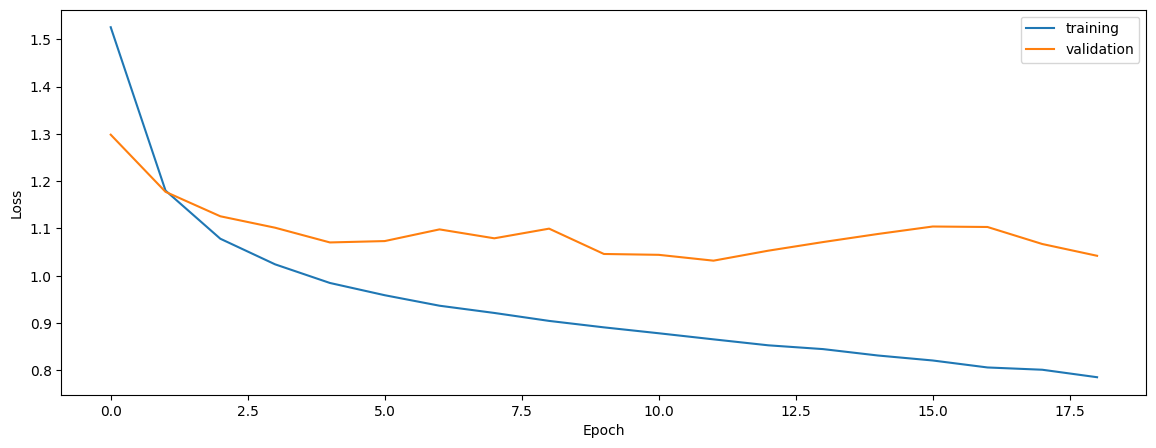

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6695402983621668
0.6148124219322049
0.6154539349846386


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6027642446580875
0.5979096846522388
0.5355399179710512


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6022904520008431
0.5876072871516395


0.5448127989951611


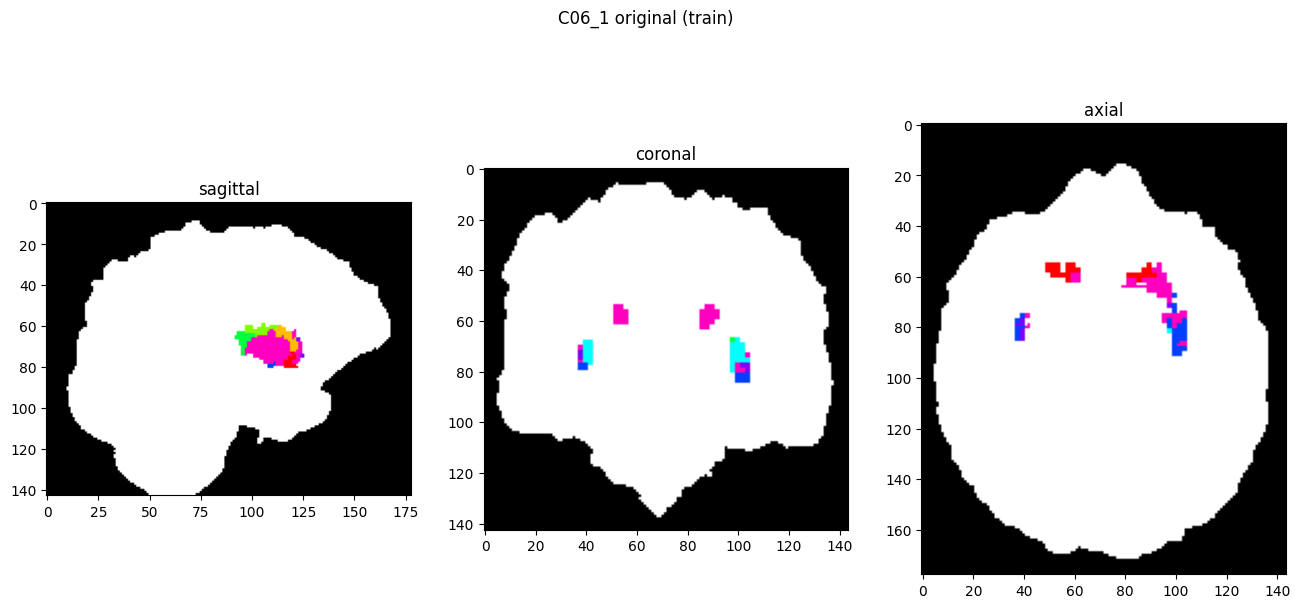

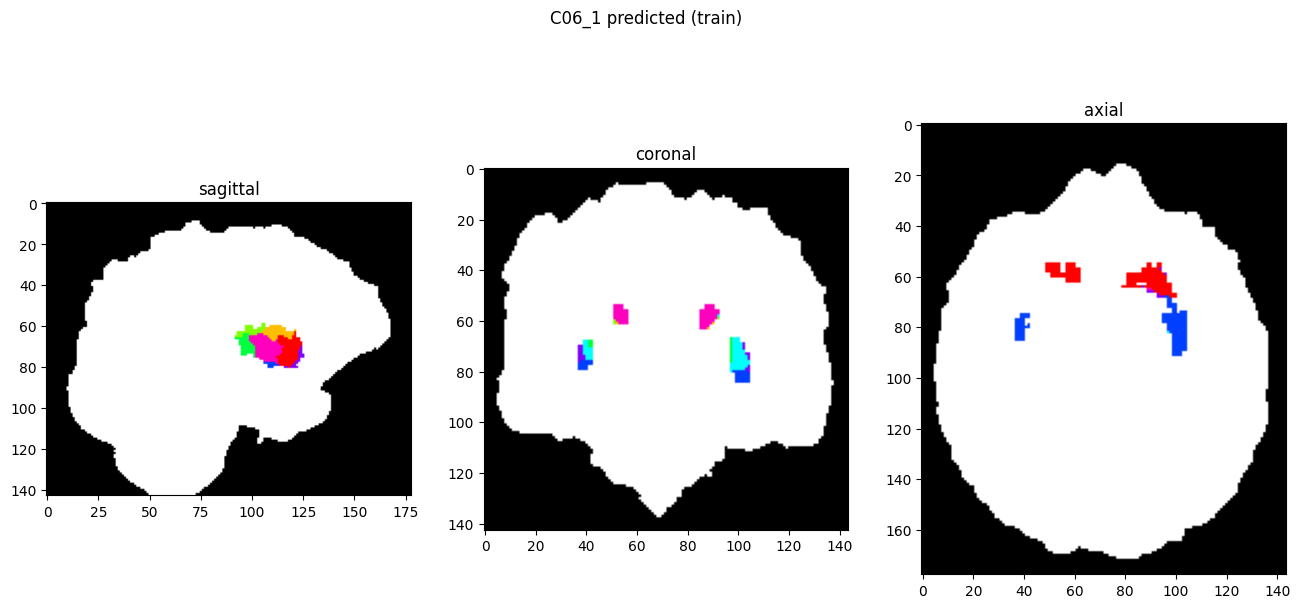

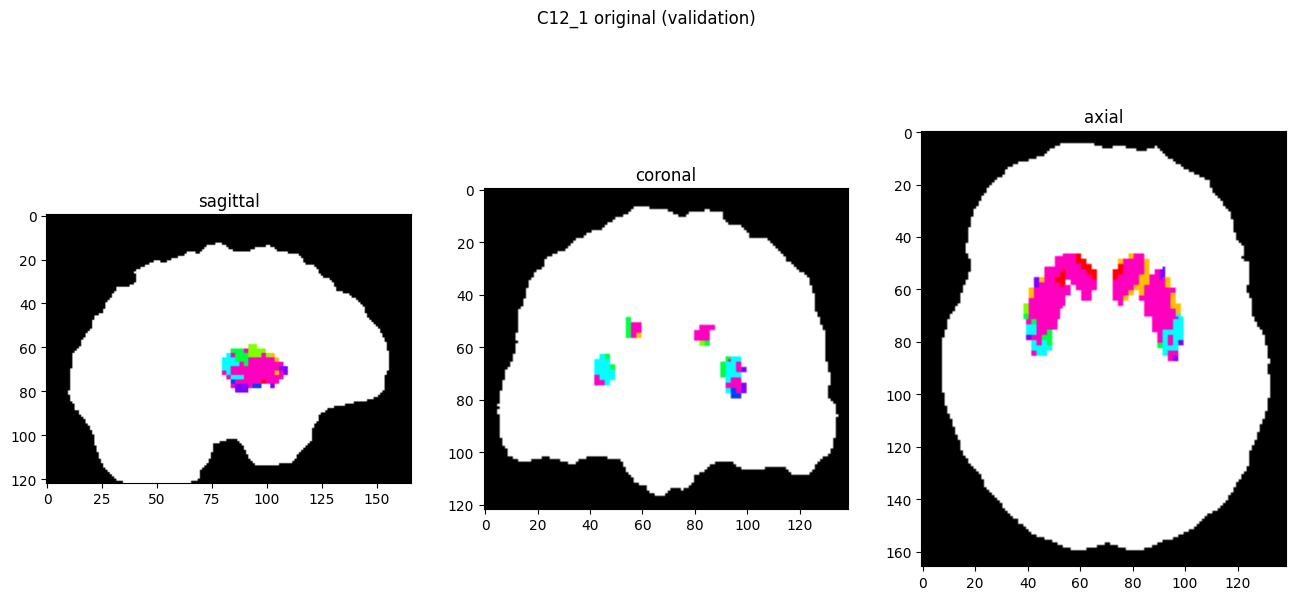

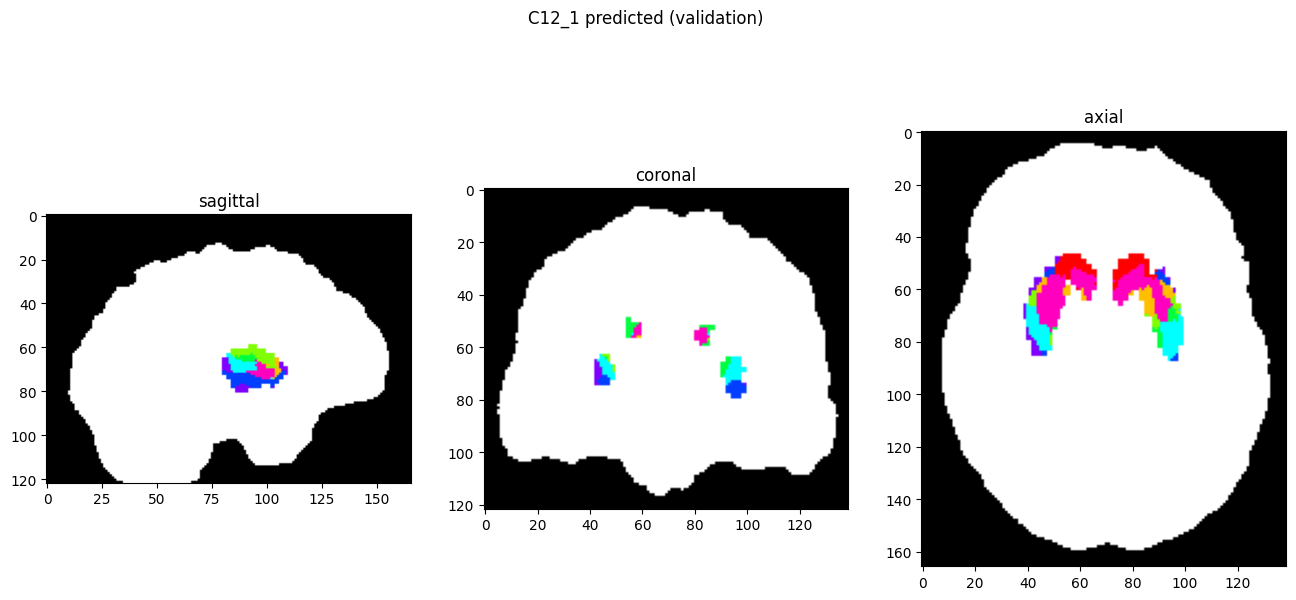

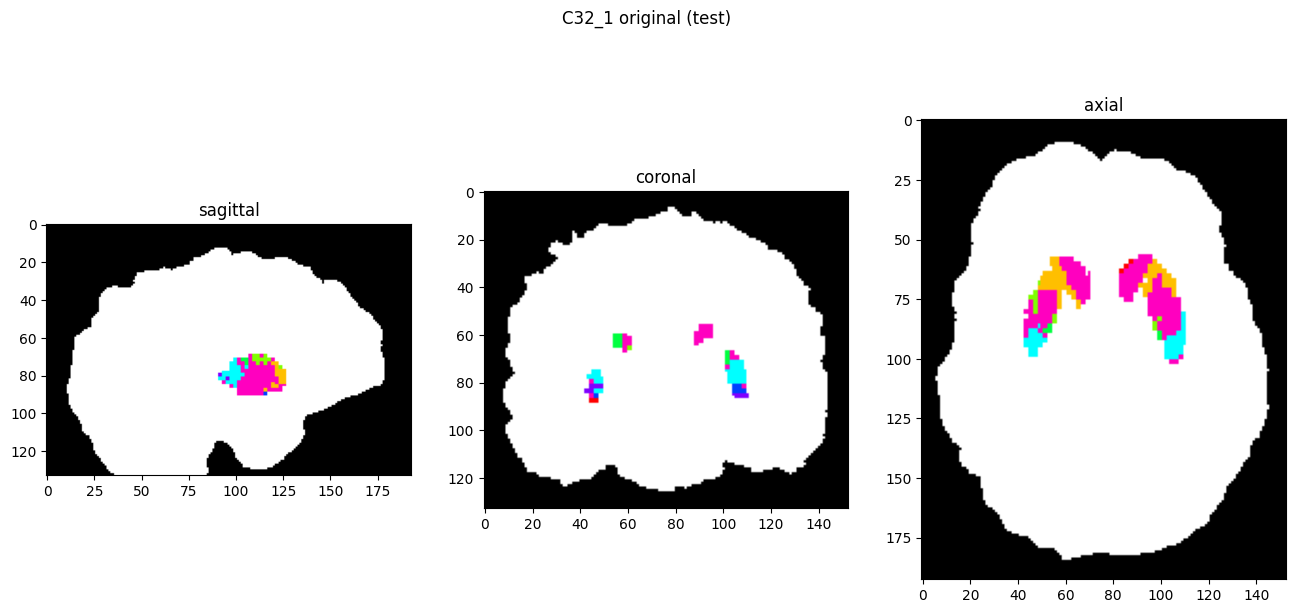

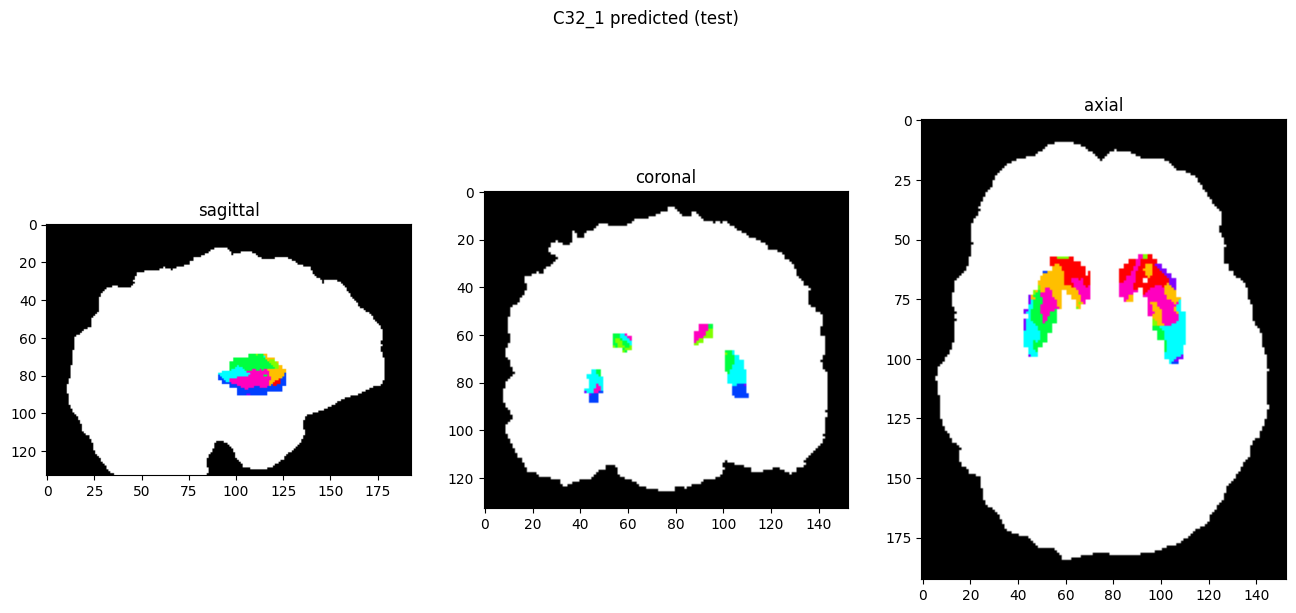

In [10]:
showResults(model, gen, threshold=0)